1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성합니다.

In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ace17f68550>)

In [3]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [4]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 (RGB 순서 )
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

# 인물 모드 사진 - 아웃포커싱

(1296, 730, 3)


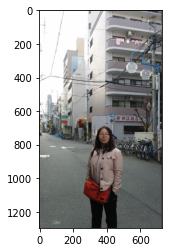

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/persion.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 시멘틱 세그멘테이션 - PixelLib 
  PASCAL VOC 데이터로 학습된 모델을 사용

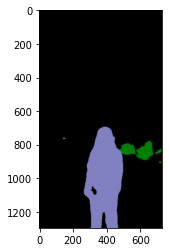

In [6]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용

# segvalues : class_ids(어떤 물체인지)와 masks 
# output : 세그멘테이션이 된 결과 ( BGR 순서)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [7]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle
car
person


In [8]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

- 사람만 따로 이미지 출력

In [9]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
persion_color = (128,128,192) 

(1296, 730)


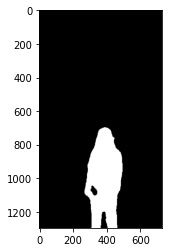

In [10]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==persion_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
# seg_color, seg_map은 RGB 형식
img_mask = seg_map.astype(np.uint8) * 255


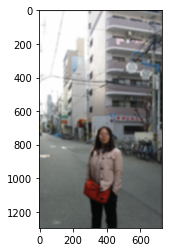

In [11]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
  cv2.bitwise_not(): 이미지가 반전
  cv2.bitwise_and(): 0인 픽셀(사람)은 모두 0이됨 --> 배경만 남음

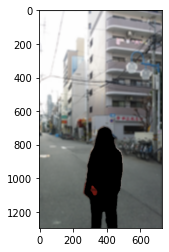

In [12]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (RGB(GRAY?)형식을 BGR 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐린 배경과 원본 영상 합성

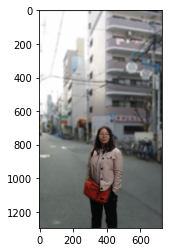

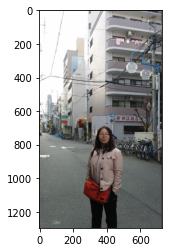

In [13]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(사람), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 배경전환 크로마키 사진

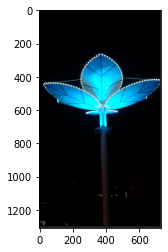

(1309, 732, 3)


In [14]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_1.png'  
bg_img_orig = cv2.imread(bg_img_path) 
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()
print(bg_img_orig.shape)

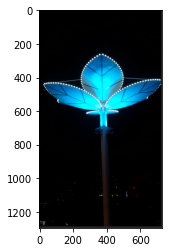

(1296, 730, 3)


In [15]:
# concat을 하려면, 두 이미지 size가 같아야 한다. 

bg_img = cv2.resize( bg_img_orig, (img_orig.shape[1], img_orig.shape[0]) )

plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
plt.show()
print(bg_img.shape)

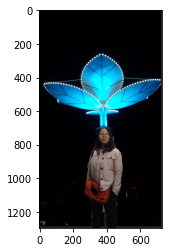

In [16]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(사람), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, bg_img)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


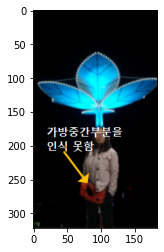

In [17]:
prob_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/persion_prob.png'  
prob_img = cv2.imread(prob_path) 
plt.imshow(cv2.cvtColor(prob_img, cv2.COLOR_BGR2RGB))
plt.show()

(780, 1376, 3)


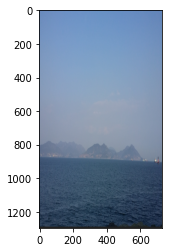

(1296, 730, 3)


In [18]:
sea_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background_see.png'  
sea_img_orig = cv2.imread(sea_img_path) 

print(sea_img_orig.shape)

sea_img = cv2.resize( sea_img_orig, (img_orig.shape[1], img_orig.shape[0]) )

plt.imshow(cv2.cvtColor(sea_img, cv2.COLOR_BGR2RGB))
plt.show()
print(sea_img.shape)

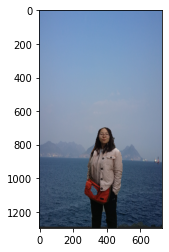

In [19]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(사람), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, sea_img)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 동물 사진

(1298, 968, 3)


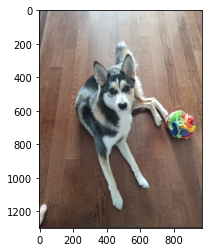

In [20]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

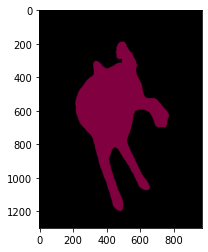

In [21]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용

# segvalues : class_ids(어떤 물체인지)와 masks 
# output : 세그멘테이션이 된 결과 ( BGR 순서)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [22]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [23]:
colormap[12] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 12번째인 개)

array([ 64,   0, 128])

(1298, 968)


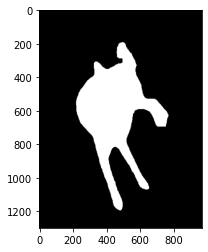

In [24]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
dog_color = (128,0,64) 

seg_map = np.all(output==dog_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
# seg_color, seg_map은 RGB 형식
img_mask = seg_map.astype(np.uint8) * 255

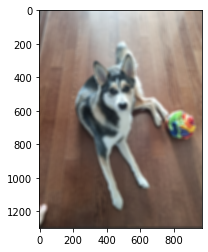

In [25]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (20,20))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

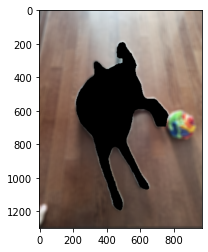

In [26]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (RGB(GRAY?)형식을 BGR 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 동물이 255 였으나
# 연산을 하고 나면 배경은 255 동물은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

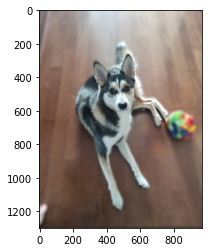

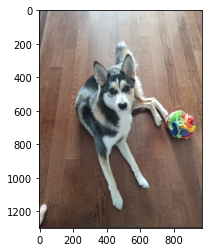

In [27]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다
# img_mask_color : 255(동물), 0(배경), BGR 형식
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

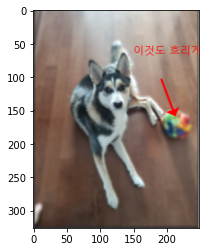

In [28]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog_outpocusing_prob.png'  
img_orig = cv2.imread(img_path) 
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 솔루션 : 
 공모양 장난감도 물체로 인식하여, 배경으로 blur 처리 되지 않고 outpocusing 대상으로 처리
 -. 만약, pascal voc에서 공을 인식한다면, 공을 별도 이미지로 분리하고, ( dog+blur 배경 ) + 공 이미지를 concat하는 방식이 가능해보이는데, 
 -. CocoDetection에서 공에 대한 데이타 클래서로 처리해볼까?. 
 
 

In [33]:
from pixellib.instance import instance_segmentation
import os

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
coco_model_file = os.path.join(model_dir, 'mask_rcnn_coco.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.2/mask_rcnn_coco.h5'
# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, coco_model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/mask_rcnn_coco.h5',
 <http.client.HTTPMessage at 0x7acdfc722d60>)

In [43]:
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [56]:
from pixellib.instance import instance_segmentation
import os


# 1. 객체 분리기 설정
segment_image = instance_segmentation()
segment_image.load_model(coco_model_file)  # COCO 모델 로드

# 2. 분리 대상 클래스 정의
#target_classes = ["dog", "sports ball"]
target_classes = {
    "dog": True,
    "sports ball": True
}

# 3. 이미지 로드
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png'  
img_orig = cv2.imread(img_path)

# 분리 실행
segmask, output = segment_image.segmentImage(
    img_path,
    segment_target_classes=target_classes,
    extract_segmented_objects=True,
    output_image_name="segmented_output.png"
)

# 분리된 마스크 이미지에서 색상 추출
seg_img = cv2.imread("segmented_output.png")
seg_img_rgb = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)

# 고유한 색상 추출
unique_colors = np.unique(seg_img_rgb.reshape(-1, 3), axis=0)

print("🎨 추출된 색상 목록 (RGB):")
for color in unique_colors:
    print(tuple(color))

Processed image saved successfully in your current working directory.
🎨 추출된 색상 목록 (RGB):
(2, 30, 29)
(2, 32, 27)
(2, 36, 32)
(3, 26, 50)
(3, 27, 55)
(3, 27, 57)
(3, 29, 33)
(4, 21, 42)
(4, 22, 39)
(4, 24, 48)
(4, 25, 54)
(4, 26, 47)
(5, 22, 37)
(5, 22, 41)
(5, 23, 44)
(5, 25, 49)
(5, 26, 51)
(5, 26, 54)
(5, 27, 47)
(5, 28, 58)
(5, 31, 68)
(6, 9, 138)
(6, 10, 139)
(6, 10, 140)
(6, 11, 140)
(6, 22, 37)
(6, 23, 43)
(6, 26, 48)
(6, 26, 53)
(6, 27, 54)
(6, 27, 57)
(6, 27, 58)
(6, 28, 59)
(6, 29, 62)
(6, 31, 25)
(6, 31, 61)
(6, 32, 35)
(6, 49, 99)
(7, 9, 139)
(7, 9, 140)
(7, 9, 141)
(7, 10, 139)
(7, 10, 140)
(7, 10, 141)
(7, 11, 139)
(7, 11, 140)
(7, 11, 141)
(7, 12, 141)
(7, 12, 142)
(7, 16, 147)
(7, 16, 148)
(7, 23, 38)
(7, 23, 44)
(7, 26, 50)
(7, 26, 53)
(7, 27, 36)
(7, 27, 52)
(7, 28, 49)
(7, 28, 57)
(7, 29, 34)
(7, 30, 61)
(7, 31, 25)
(7, 35, 33)
(7, 37, 72)
(7, 49, 98)
(7, 59, 106)
(8, 9, 141)
(8, 10, 140)
(8, 10, 141)
(8, 11, 140)
(8, 11, 141)
(8, 11, 142)
(8, 11, 143)
(8, 12, 141)
(8

(20, 58, 85)
(20, 58, 86)
(20, 60, 50)
(20, 61, 93)
(20, 67, 115)
(20, 68, 120)
(20, 71, 69)
(21, 14, 142)
(21, 15, 141)
(21, 15, 142)
(21, 15, 143)
(21, 16, 142)
(21, 16, 143)
(21, 16, 144)
(21, 16, 145)
(21, 17, 142)
(21, 17, 143)
(21, 17, 144)
(21, 17, 145)
(21, 18, 143)
(21, 18, 144)
(21, 18, 145)
(21, 18, 146)
(21, 19, 144)
(21, 19, 145)
(21, 19, 146)
(21, 19, 147)
(21, 20, 146)
(21, 20, 147)
(21, 20, 148)
(21, 20, 149)
(21, 21, 147)
(21, 21, 148)
(21, 21, 149)
(21, 21, 150)
(21, 21, 151)
(21, 22, 148)
(21, 22, 149)
(21, 22, 151)
(21, 23, 149)
(21, 23, 150)
(21, 23, 151)
(21, 23, 152)
(21, 23, 153)
(21, 23, 154)
(21, 24, 149)
(21, 24, 150)
(21, 24, 151)
(21, 24, 152)
(21, 24, 153)
(21, 24, 154)
(21, 24, 155)
(21, 24, 156)
(21, 24, 157)
(21, 25, 151)
(21, 25, 152)
(21, 25, 153)
(21, 25, 154)
(21, 25, 155)
(21, 25, 156)
(21, 25, 157)
(21, 25, 158)
(21, 26, 152)
(21, 26, 153)
(21, 26, 154)
(21, 26, 155)
(21, 26, 156)
(21, 26, 157)
(21, 26, 158)
(21, 26, 159)
(21, 26, 160)
(21, 27, 37

(29, 26, 154)
(29, 27, 25)
(29, 27, 27)
(29, 27, 28)
(29, 27, 29)
(29, 27, 31)
(29, 27, 152)
(29, 27, 153)
(29, 27, 154)
(29, 27, 155)
(29, 27, 156)
(29, 28, 25)
(29, 28, 27)
(29, 28, 28)
(29, 28, 29)
(29, 28, 30)
(29, 28, 153)
(29, 28, 154)
(29, 28, 155)
(29, 28, 156)
(29, 29, 24)
(29, 29, 30)
(29, 29, 153)
(29, 29, 154)
(29, 29, 155)
(29, 29, 156)
(29, 29, 157)
(29, 29, 159)
(29, 30, 25)
(29, 30, 32)
(29, 30, 153)
(29, 30, 154)
(29, 30, 155)
(29, 30, 156)
(29, 30, 157)
(29, 30, 158)
(29, 30, 159)
(29, 30, 160)
(29, 30, 161)
(29, 31, 25)
(29, 31, 27)
(29, 31, 30)
(29, 31, 40)
(29, 31, 154)
(29, 31, 156)
(29, 31, 157)
(29, 31, 158)
(29, 31, 159)
(29, 31, 160)
(29, 31, 161)
(29, 31, 162)
(29, 32, 33)
(29, 32, 156)
(29, 32, 157)
(29, 32, 158)
(29, 32, 159)
(29, 32, 160)
(29, 32, 161)
(29, 32, 162)
(29, 32, 163)
(29, 33, 47)
(29, 33, 157)
(29, 33, 158)
(29, 33, 159)
(29, 33, 160)
(29, 33, 161)
(29, 33, 162)
(29, 33, 163)
(29, 33, 164)
(29, 33, 166)
(29, 34, 33)
(29, 34, 160)
(29, 34, 161)

(33, 70, 99)
(33, 74, 87)
(33, 76, 93)
(33, 79, 83)
(33, 97, 137)
(33, 119, 32)
(33, 120, 32)
(34, 21, 13)
(34, 21, 20)
(34, 23, 17)
(34, 23, 21)
(34, 24, 18)
(34, 24, 21)
(34, 24, 22)
(34, 24, 24)
(34, 24, 150)
(34, 24, 151)
(34, 25, 18)
(34, 25, 19)
(34, 25, 20)
(34, 25, 22)
(34, 25, 23)
(34, 25, 149)
(34, 25, 150)
(34, 25, 151)
(34, 25, 152)
(34, 25, 153)
(34, 26, 20)
(34, 26, 22)
(34, 26, 23)
(34, 26, 24)
(34, 26, 27)
(34, 26, 151)
(34, 26, 152)
(34, 26, 153)
(34, 27, 18)
(34, 27, 19)
(34, 27, 20)
(34, 27, 21)
(34, 27, 22)
(34, 27, 24)
(34, 27, 25)
(34, 27, 26)
(34, 27, 27)
(34, 27, 151)
(34, 27, 152)
(34, 27, 153)
(34, 27, 154)
(34, 28, 22)
(34, 28, 26)
(34, 28, 28)
(34, 28, 29)
(34, 28, 151)
(34, 28, 152)
(34, 28, 154)
(34, 28, 155)
(34, 29, 21)
(34, 29, 25)
(34, 29, 26)
(34, 29, 28)
(34, 29, 150)
(34, 29, 152)
(34, 29, 153)
(34, 29, 154)
(34, 29, 155)
(34, 29, 156)
(34, 29, 157)
(34, 30, 26)
(34, 30, 27)
(34, 30, 28)
(34, 30, 29)
(34, 30, 31)
(34, 30, 151)
(34, 30, 154)
(34, 30,

(40, 36, 159)
(40, 36, 160)
(40, 36, 161)
(40, 36, 162)
(40, 36, 163)
(40, 36, 165)
(40, 37, 32)
(40, 37, 34)
(40, 37, 35)
(40, 37, 37)
(40, 37, 38)
(40, 37, 39)
(40, 37, 159)
(40, 37, 160)
(40, 37, 163)
(40, 37, 164)
(40, 37, 165)
(40, 37, 166)
(40, 37, 167)
(40, 37, 168)
(40, 38, 32)
(40, 38, 34)
(40, 38, 35)
(40, 38, 36)
(40, 38, 37)
(40, 38, 38)
(40, 38, 40)
(40, 38, 162)
(40, 38, 163)
(40, 38, 164)
(40, 38, 165)
(40, 38, 166)
(40, 38, 167)
(40, 38, 169)
(40, 39, 36)
(40, 39, 37)
(40, 39, 40)
(40, 39, 41)
(40, 39, 161)
(40, 39, 162)
(40, 39, 163)
(40, 39, 164)
(40, 39, 165)
(40, 39, 166)
(40, 39, 167)
(40, 39, 168)
(40, 39, 169)
(40, 39, 170)
(40, 40, 37)
(40, 40, 38)
(40, 40, 39)
(40, 40, 40)
(40, 40, 41)
(40, 40, 44)
(40, 40, 163)
(40, 40, 164)
(40, 40, 165)
(40, 40, 166)
(40, 40, 167)
(40, 40, 168)
(40, 40, 169)
(40, 40, 170)
(40, 41, 40)
(40, 41, 42)
(40, 41, 43)
(40, 41, 164)
(40, 41, 165)
(40, 41, 166)
(40, 41, 167)
(40, 41, 168)
(40, 41, 169)
(40, 41, 170)
(40, 41, 171)
(40,

(44, 53, 184)
(44, 53, 185)
(44, 53, 186)
(44, 54, 45)
(44, 54, 59)
(44, 54, 61)
(44, 54, 183)
(44, 54, 184)
(44, 54, 185)
(44, 54, 186)
(44, 54, 187)
(44, 55, 58)
(44, 55, 59)
(44, 55, 60)
(44, 55, 61)
(44, 55, 185)
(44, 55, 186)
(44, 55, 187)
(44, 55, 188)
(44, 55, 189)
(44, 56, 185)
(44, 56, 186)
(44, 56, 187)
(44, 56, 188)
(44, 56, 189)
(44, 56, 190)
(44, 57, 91)
(44, 57, 188)
(44, 57, 189)
(44, 57, 190)
(44, 57, 191)
(44, 57, 192)
(44, 58, 46)
(44, 58, 85)
(44, 58, 105)
(44, 58, 190)
(44, 58, 191)
(44, 58, 193)
(44, 59, 96)
(44, 59, 101)
(44, 59, 103)
(44, 59, 194)
(44, 60, 92)
(44, 60, 102)
(44, 60, 106)
(44, 60, 195)
(44, 60, 198)
(44, 61, 105)
(44, 61, 196)
(44, 61, 198)
(44, 62, 94)
(44, 62, 111)
(44, 63, 49)
(44, 65, 80)
(44, 66, 97)
(44, 71, 81)
(44, 73, 84)
(44, 73, 114)
(44, 74, 50)
(44, 74, 114)
(44, 77, 66)
(44, 80, 97)
(44, 81, 82)
(44, 81, 97)
(44, 91, 94)
(44, 92, 88)
(44, 92, 143)
(44, 97, 95)
(44, 100, 52)
(44, 101, 48)
(44, 101, 50)
(44, 106, 151)
(44, 121, 40)
(45

(49, 53, 176)
(49, 53, 177)
(49, 53, 178)
(49, 53, 179)
(49, 53, 180)
(49, 53, 181)
(49, 53, 182)
(49, 53, 183)
(49, 53, 184)
(49, 54, 40)
(49, 54, 57)
(49, 54, 178)
(49, 54, 179)
(49, 54, 180)
(49, 54, 181)
(49, 54, 182)
(49, 54, 183)
(49, 54, 184)
(49, 54, 185)
(49, 54, 186)
(49, 55, 44)
(49, 55, 57)
(49, 55, 76)
(49, 55, 179)
(49, 55, 180)
(49, 55, 181)
(49, 55, 182)
(49, 55, 183)
(49, 55, 184)
(49, 55, 185)
(49, 55, 186)
(49, 55, 187)
(49, 56, 54)
(49, 56, 56)
(49, 56, 183)
(49, 56, 184)
(49, 56, 185)
(49, 56, 186)
(49, 56, 187)
(49, 56, 188)
(49, 56, 189)
(49, 57, 59)
(49, 57, 184)
(49, 57, 185)
(49, 57, 186)
(49, 57, 187)
(49, 57, 188)
(49, 57, 189)
(49, 57, 190)
(49, 58, 62)
(49, 58, 63)
(49, 58, 186)
(49, 58, 187)
(49, 58, 188)
(49, 58, 189)
(49, 58, 190)
(49, 58, 191)
(49, 58, 192)
(49, 59, 61)
(49, 59, 63)
(49, 59, 89)
(49, 59, 186)
(49, 59, 187)
(49, 59, 188)
(49, 59, 189)
(49, 59, 190)
(49, 59, 191)
(49, 59, 192)
(49, 59, 193)
(49, 59, 194)
(49, 60, 48)
(49, 60, 62)
(49, 60

(53, 66, 118)
(53, 66, 197)
(53, 66, 198)
(53, 66, 199)
(53, 66, 200)
(53, 66, 201)
(53, 66, 202)
(53, 67, 42)
(53, 67, 53)
(53, 67, 98)
(53, 67, 112)
(53, 67, 113)
(53, 67, 114)
(53, 67, 115)
(53, 67, 116)
(53, 67, 199)
(53, 67, 200)
(53, 67, 203)
(53, 68, 65)
(53, 68, 111)
(53, 68, 115)
(53, 68, 201)
(53, 69, 110)
(53, 69, 116)
(53, 69, 118)
(53, 69, 121)
(53, 69, 203)
(53, 69, 207)
(53, 70, 114)
(53, 70, 117)
(53, 70, 118)
(53, 70, 122)
(53, 70, 205)
(53, 71, 113)
(53, 71, 114)
(53, 72, 117)
(53, 75, 86)
(53, 88, 135)
(53, 90, 97)
(53, 92, 65)
(53, 93, 88)
(53, 100, 141)
(53, 102, 104)
(53, 103, 60)
(53, 112, 161)
(53, 118, 148)
(54, 28, 36)
(54, 29, 50)
(54, 31, 31)
(54, 32, 37)
(54, 34, 22)
(54, 34, 24)
(54, 34, 25)
(54, 34, 26)
(54, 34, 27)
(54, 35, 26)
(54, 35, 28)
(54, 35, 29)
(54, 35, 31)
(54, 35, 32)
(54, 35, 34)
(54, 36, 26)
(54, 36, 28)
(54, 36, 29)
(54, 36, 30)
(54, 36, 32)
(54, 36, 34)
(54, 36, 57)
(54, 37, 26)
(54, 37, 27)
(54, 37, 28)
(54, 37, 29)
(54, 37, 30)
(54, 37, 

(57, 50, 172)
(57, 50, 173)
(57, 50, 174)
(57, 50, 175)
(57, 50, 176)
(57, 50, 177)
(57, 51, 32)
(57, 51, 33)
(57, 51, 41)
(57, 51, 45)
(57, 51, 47)
(57, 51, 48)
(57, 51, 171)
(57, 51, 172)
(57, 51, 173)
(57, 51, 174)
(57, 51, 176)
(57, 51, 177)
(57, 52, 42)
(57, 52, 44)
(57, 52, 45)
(57, 52, 48)
(57, 52, 49)
(57, 52, 51)
(57, 52, 174)
(57, 52, 175)
(57, 52, 176)
(57, 52, 177)
(57, 52, 178)
(57, 52, 179)
(57, 52, 180)
(57, 53, 51)
(57, 53, 53)
(57, 53, 175)
(57, 53, 176)
(57, 53, 177)
(57, 53, 178)
(57, 53, 179)
(57, 53, 180)
(57, 53, 181)
(57, 54, 50)
(57, 54, 51)
(57, 54, 56)
(57, 54, 174)
(57, 54, 175)
(57, 54, 176)
(57, 54, 177)
(57, 54, 178)
(57, 54, 179)
(57, 54, 180)
(57, 54, 181)
(57, 54, 182)
(57, 54, 183)
(57, 54, 184)
(57, 55, 56)
(57, 55, 175)
(57, 55, 176)
(57, 55, 177)
(57, 55, 178)
(57, 55, 179)
(57, 55, 180)
(57, 55, 181)
(57, 55, 182)
(57, 55, 183)
(57, 55, 186)
(57, 56, 54)
(57, 56, 55)
(57, 56, 177)
(57, 56, 178)
(57, 56, 179)
(57, 56, 180)
(57, 56, 181)
(57, 56, 182

(62, 39, 37)
(62, 40, 27)
(62, 40, 28)
(62, 40, 29)
(62, 40, 30)
(62, 40, 32)
(62, 40, 55)
(62, 40, 62)
(62, 41, 30)
(62, 41, 32)
(62, 41, 35)
(62, 41, 36)
(62, 42, 31)
(62, 42, 32)
(62, 42, 33)
(62, 42, 34)
(62, 42, 35)
(62, 42, 36)
(62, 42, 37)
(62, 42, 39)
(62, 43, 31)
(62, 43, 33)
(62, 43, 34)
(62, 43, 35)
(62, 43, 36)
(62, 43, 37)
(62, 43, 38)
(62, 43, 39)
(62, 43, 40)
(62, 44, 32)
(62, 44, 33)
(62, 44, 34)
(62, 44, 35)
(62, 44, 36)
(62, 44, 37)
(62, 44, 38)
(62, 44, 39)
(62, 44, 40)
(62, 44, 41)
(62, 44, 42)
(62, 44, 44)
(62, 45, 34)
(62, 45, 35)
(62, 45, 36)
(62, 45, 37)
(62, 45, 38)
(62, 45, 39)
(62, 45, 40)
(62, 45, 41)
(62, 45, 42)
(62, 45, 45)
(62, 46, 33)
(62, 46, 37)
(62, 46, 38)
(62, 46, 39)
(62, 46, 40)
(62, 46, 41)
(62, 46, 42)
(62, 46, 43)
(62, 46, 46)
(62, 46, 47)
(62, 47, 37)
(62, 47, 38)
(62, 47, 39)
(62, 47, 40)
(62, 47, 41)
(62, 47, 42)
(62, 47, 43)
(62, 47, 44)
(62, 47, 46)
(62, 47, 164)
(62, 47, 166)
(62, 47, 169)
(62, 48, 39)
(62, 48, 40)
(62, 48, 41)
(62, 48, 

(65, 57, 58)
(65, 57, 176)
(65, 57, 177)
(65, 57, 181)
(65, 57, 182)
(65, 58, 51)
(65, 58, 52)
(65, 58, 55)
(65, 58, 177)
(65, 58, 178)
(65, 58, 179)
(65, 58, 180)
(65, 58, 182)
(65, 58, 183)
(65, 59, 53)
(65, 59, 56)
(65, 59, 178)
(65, 59, 179)
(65, 59, 180)
(65, 59, 181)
(65, 59, 182)
(65, 59, 183)
(65, 59, 184)
(65, 59, 185)
(65, 59, 186)
(65, 60, 53)
(65, 60, 56)
(65, 60, 57)
(65, 60, 60)
(65, 60, 179)
(65, 60, 180)
(65, 60, 181)
(65, 60, 182)
(65, 60, 183)
(65, 60, 185)
(65, 61, 52)
(65, 61, 55)
(65, 61, 57)
(65, 61, 58)
(65, 61, 59)
(65, 61, 61)
(65, 61, 181)
(65, 61, 182)
(65, 61, 183)
(65, 61, 184)
(65, 61, 185)
(65, 61, 186)
(65, 61, 187)
(65, 61, 188)
(65, 62, 54)
(65, 62, 55)
(65, 62, 57)
(65, 62, 58)
(65, 62, 62)
(65, 62, 63)
(65, 62, 65)
(65, 62, 69)
(65, 62, 182)
(65, 62, 183)
(65, 62, 184)
(65, 62, 185)
(65, 62, 186)
(65, 62, 187)
(65, 62, 188)
(65, 62, 190)
(65, 63, 58)
(65, 63, 59)
(65, 63, 61)
(65, 63, 76)
(65, 63, 183)
(65, 63, 184)
(65, 63, 185)
(65, 63, 186)
(65, 6

(68, 63, 44)
(68, 63, 57)
(68, 63, 58)
(68, 63, 59)
(68, 63, 60)
(68, 63, 62)
(68, 63, 182)
(68, 63, 183)
(68, 63, 184)
(68, 63, 185)
(68, 63, 186)
(68, 63, 188)
(68, 63, 192)
(68, 64, 56)
(68, 64, 58)
(68, 64, 59)
(68, 64, 60)
(68, 64, 61)
(68, 64, 183)
(68, 64, 185)
(68, 64, 186)
(68, 64, 187)
(68, 64, 188)
(68, 64, 189)
(68, 65, 57)
(68, 65, 63)
(68, 65, 184)
(68, 65, 185)
(68, 65, 186)
(68, 65, 187)
(68, 65, 188)
(68, 65, 189)
(68, 65, 190)
(68, 65, 191)
(68, 66, 64)
(68, 66, 65)
(68, 66, 186)
(68, 66, 187)
(68, 66, 188)
(68, 66, 189)
(68, 66, 190)
(68, 66, 191)
(68, 66, 192)
(68, 66, 193)
(68, 67, 64)
(68, 67, 81)
(68, 67, 186)
(68, 67, 187)
(68, 67, 188)
(68, 67, 189)
(68, 67, 190)
(68, 67, 191)
(68, 67, 192)
(68, 67, 194)
(68, 68, 67)
(68, 68, 69)
(68, 68, 83)
(68, 68, 189)
(68, 68, 190)
(68, 68, 191)
(68, 68, 192)
(68, 68, 193)
(68, 68, 194)
(68, 68, 195)
(68, 68, 196)
(68, 68, 197)
(68, 69, 64)
(68, 69, 66)
(68, 69, 67)
(68, 69, 190)
(68, 69, 191)
(68, 69, 192)
(68, 69, 193)
(

(72, 52, 41)
(72, 52, 42)
(72, 52, 43)
(72, 52, 44)
(72, 52, 45)
(72, 52, 46)
(72, 52, 47)
(72, 52, 49)
(72, 53, 38)
(72, 53, 39)
(72, 53, 40)
(72, 53, 41)
(72, 53, 42)
(72, 53, 43)
(72, 53, 44)
(72, 53, 45)
(72, 53, 46)
(72, 53, 47)
(72, 53, 48)
(72, 53, 49)
(72, 53, 50)
(72, 54, 41)
(72, 54, 42)
(72, 54, 43)
(72, 54, 44)
(72, 54, 45)
(72, 54, 46)
(72, 54, 47)
(72, 54, 48)
(72, 54, 49)
(72, 54, 50)
(72, 54, 51)
(72, 54, 52)
(72, 54, 53)
(72, 55, 34)
(72, 55, 42)
(72, 55, 43)
(72, 55, 44)
(72, 55, 45)
(72, 55, 46)
(72, 55, 47)
(72, 55, 48)
(72, 55, 49)
(72, 55, 50)
(72, 55, 51)
(72, 55, 53)
(72, 56, 44)
(72, 56, 46)
(72, 56, 47)
(72, 56, 48)
(72, 56, 49)
(72, 56, 50)
(72, 56, 51)
(72, 56, 56)
(72, 56, 173)
(72, 57, 46)
(72, 57, 47)
(72, 57, 48)
(72, 57, 49)
(72, 57, 50)
(72, 57, 51)
(72, 57, 52)
(72, 57, 53)
(72, 57, 54)
(72, 57, 172)
(72, 57, 173)
(72, 58, 47)
(72, 58, 49)
(72, 58, 50)
(72, 58, 51)
(72, 58, 52)
(72, 58, 53)
(72, 58, 54)
(72, 58, 55)
(72, 58, 57)
(72, 58, 174)
(72, 58,

(74, 85, 217)
(74, 85, 218)
(74, 85, 219)
(74, 86, 123)
(74, 86, 131)
(74, 86, 216)
(74, 86, 217)
(74, 86, 218)
(74, 86, 219)
(74, 86, 220)
(74, 86, 221)
(74, 87, 90)
(74, 87, 92)
(74, 87, 131)
(74, 87, 136)
(74, 87, 138)
(74, 87, 139)
(74, 87, 217)
(74, 87, 218)
(74, 87, 219)
(74, 87, 220)
(74, 87, 221)
(74, 87, 222)
(74, 87, 223)
(74, 88, 92)
(74, 88, 93)
(74, 88, 137)
(74, 88, 138)
(74, 88, 220)
(74, 88, 221)
(74, 88, 222)
(74, 88, 223)
(74, 88, 224)
(74, 88, 225)
(74, 89, 95)
(74, 89, 137)
(74, 89, 139)
(74, 89, 222)
(74, 89, 223)
(74, 89, 224)
(74, 89, 225)
(74, 89, 226)
(74, 90, 132)
(74, 90, 139)
(74, 90, 143)
(74, 90, 224)
(74, 90, 225)
(74, 90, 226)
(74, 90, 227)
(74, 91, 137)
(74, 91, 142)
(74, 91, 224)
(74, 91, 226)
(74, 91, 227)
(74, 91, 228)
(74, 92, 122)
(74, 92, 133)
(74, 92, 138)
(74, 92, 143)
(74, 92, 226)
(74, 92, 228)
(74, 93, 101)
(74, 94, 100)
(74, 104, 106)
(74, 114, 108)
(74, 114, 124)
(74, 115, 97)
(74, 118, 92)
(74, 119, 125)
(74, 138, 98)
(74, 146, 112)
(74, 1

(77, 76, 84)
(77, 76, 116)
(77, 76, 195)
(77, 76, 196)
(77, 76, 197)
(77, 76, 198)
(77, 76, 199)
(77, 76, 200)
(77, 76, 201)
(77, 76, 202)
(77, 77, 73)
(77, 77, 75)
(77, 77, 78)
(77, 77, 79)
(77, 77, 80)
(77, 77, 197)
(77, 77, 198)
(77, 77, 199)
(77, 77, 200)
(77, 77, 201)
(77, 77, 202)
(77, 77, 203)
(77, 77, 204)
(77, 77, 205)
(77, 77, 206)
(77, 78, 73)
(77, 78, 76)
(77, 78, 80)
(77, 78, 198)
(77, 78, 199)
(77, 78, 200)
(77, 78, 201)
(77, 78, 202)
(77, 78, 203)
(77, 78, 204)
(77, 78, 205)
(77, 78, 206)
(77, 78, 207)
(77, 79, 76)
(77, 79, 200)
(77, 79, 201)
(77, 79, 202)
(77, 79, 203)
(77, 79, 204)
(77, 79, 205)
(77, 79, 206)
(77, 79, 207)
(77, 79, 208)
(77, 80, 78)
(77, 80, 79)
(77, 80, 81)
(77, 80, 82)
(77, 80, 84)
(77, 80, 201)
(77, 80, 202)
(77, 80, 203)
(77, 80, 204)
(77, 80, 205)
(77, 80, 206)
(77, 80, 207)
(77, 80, 208)
(77, 80, 209)
(77, 80, 210)
(77, 80, 211)
(77, 81, 80)
(77, 81, 82)
(77, 81, 128)
(77, 81, 204)
(77, 81, 205)
(77, 81, 206)
(77, 81, 207)
(77, 81, 208)
(77, 81, 

(81, 55, 45)
(81, 55, 46)
(81, 55, 51)
(81, 56, 42)
(81, 56, 43)
(81, 56, 44)
(81, 56, 45)
(81, 56, 46)
(81, 56, 47)
(81, 56, 49)
(81, 56, 52)
(81, 57, 43)
(81, 57, 44)
(81, 57, 45)
(81, 57, 46)
(81, 57, 47)
(81, 57, 48)
(81, 57, 49)
(81, 57, 50)
(81, 57, 51)
(81, 57, 53)
(81, 57, 55)
(81, 57, 99)
(81, 58, 42)
(81, 58, 43)
(81, 58, 44)
(81, 58, 45)
(81, 58, 46)
(81, 58, 47)
(81, 58, 48)
(81, 58, 49)
(81, 58, 50)
(81, 58, 51)
(81, 58, 52)
(81, 58, 53)
(81, 58, 54)
(81, 59, 44)
(81, 59, 45)
(81, 59, 46)
(81, 59, 47)
(81, 59, 48)
(81, 59, 49)
(81, 59, 50)
(81, 59, 51)
(81, 59, 53)
(81, 59, 54)
(81, 60, 46)
(81, 60, 47)
(81, 60, 48)
(81, 60, 49)
(81, 60, 50)
(81, 60, 51)
(81, 60, 52)
(81, 60, 53)
(81, 60, 54)
(81, 60, 55)
(81, 61, 47)
(81, 61, 48)
(81, 61, 49)
(81, 61, 50)
(81, 61, 51)
(81, 61, 52)
(81, 61, 53)
(81, 61, 54)
(81, 61, 55)
(81, 61, 56)
(81, 61, 58)
(81, 62, 48)
(81, 62, 49)
(81, 62, 50)
(81, 62, 51)
(81, 62, 52)
(81, 62, 53)
(81, 62, 54)
(81, 62, 55)
(81, 62, 56)
(81, 62, 57)

(83, 88, 92)
(83, 88, 131)
(83, 88, 132)
(83, 88, 210)
(83, 88, 211)
(83, 88, 212)
(83, 88, 213)
(83, 88, 214)
(83, 88, 215)
(83, 88, 216)
(83, 88, 217)
(83, 88, 218)
(83, 89, 83)
(83, 89, 86)
(83, 89, 87)
(83, 89, 90)
(83, 89, 92)
(83, 89, 93)
(83, 89, 94)
(83, 89, 129)
(83, 89, 130)
(83, 89, 135)
(83, 89, 211)
(83, 89, 212)
(83, 89, 213)
(83, 89, 214)
(83, 89, 215)
(83, 89, 216)
(83, 89, 217)
(83, 89, 218)
(83, 89, 219)
(83, 89, 220)
(83, 90, 86)
(83, 90, 92)
(83, 90, 93)
(83, 90, 130)
(83, 90, 213)
(83, 90, 214)
(83, 90, 215)
(83, 90, 216)
(83, 90, 217)
(83, 90, 218)
(83, 90, 219)
(83, 90, 220)
(83, 90, 221)
(83, 90, 222)
(83, 91, 92)
(83, 91, 94)
(83, 91, 95)
(83, 91, 122)
(83, 91, 139)
(83, 91, 215)
(83, 91, 216)
(83, 91, 217)
(83, 91, 218)
(83, 91, 219)
(83, 91, 220)
(83, 91, 221)
(83, 91, 222)
(83, 91, 223)
(83, 91, 224)
(83, 92, 96)
(83, 92, 97)
(83, 92, 130)
(83, 92, 216)
(83, 92, 218)
(83, 92, 219)
(83, 92, 220)
(83, 92, 221)
(83, 92, 222)
(83, 92, 223)
(83, 92, 224)
(83, 92,

(86, 166, 93)
(86, 166, 97)
(86, 168, 96)
(86, 170, 93)
(86, 171, 213)
(86, 173, 101)
(86, 175, 91)
(86, 178, 91)
(86, 181, 233)
(86, 185, 93)
(86, 185, 95)
(86, 188, 93)
(86, 190, 95)
(86, 190, 98)
(87, 29, 42)
(87, 31, 45)
(87, 33, 49)
(87, 35, 37)
(87, 48, 74)
(87, 49, 36)
(87, 50, 33)
(87, 50, 34)
(87, 50, 78)
(87, 51, 33)
(87, 51, 34)
(87, 51, 35)
(87, 51, 36)
(87, 51, 37)
(87, 51, 39)
(87, 52, 32)
(87, 52, 33)
(87, 52, 47)
(87, 53, 34)
(87, 53, 41)
(87, 53, 47)
(87, 53, 52)
(87, 54, 34)
(87, 54, 35)
(87, 54, 36)
(87, 54, 37)
(87, 54, 38)
(87, 54, 39)
(87, 54, 40)
(87, 54, 47)
(87, 55, 35)
(87, 55, 36)
(87, 55, 37)
(87, 55, 39)
(87, 55, 40)
(87, 55, 41)
(87, 55, 42)
(87, 55, 43)
(87, 55, 44)
(87, 55, 50)
(87, 56, 38)
(87, 56, 39)
(87, 56, 40)
(87, 56, 41)
(87, 56, 43)
(87, 56, 45)
(87, 56, 46)
(87, 56, 47)
(87, 56, 48)
(87, 56, 49)
(87, 57, 38)
(87, 57, 41)
(87, 57, 42)
(87, 57, 43)
(87, 57, 44)
(87, 57, 45)
(87, 57, 46)
(87, 57, 47)
(87, 57, 48)
(87, 58, 40)
(87, 58, 42)
(87, 58,

(89, 66, 56)
(89, 66, 57)
(89, 66, 58)
(89, 66, 59)
(89, 66, 60)
(89, 66, 62)
(89, 66, 64)
(89, 67, 51)
(89, 67, 52)
(89, 67, 53)
(89, 67, 54)
(89, 67, 55)
(89, 67, 56)
(89, 67, 57)
(89, 67, 58)
(89, 67, 59)
(89, 67, 60)
(89, 67, 61)
(89, 67, 101)
(89, 68, 50)
(89, 68, 51)
(89, 68, 54)
(89, 68, 55)
(89, 68, 56)
(89, 68, 57)
(89, 68, 58)
(89, 68, 59)
(89, 68, 60)
(89, 68, 61)
(89, 68, 62)
(89, 68, 63)
(89, 68, 95)
(89, 69, 54)
(89, 69, 55)
(89, 69, 56)
(89, 69, 57)
(89, 69, 58)
(89, 69, 59)
(89, 69, 60)
(89, 69, 61)
(89, 69, 62)
(89, 69, 63)
(89, 69, 64)
(89, 70, 55)
(89, 70, 56)
(89, 70, 57)
(89, 70, 58)
(89, 70, 59)
(89, 70, 60)
(89, 70, 61)
(89, 70, 62)
(89, 70, 63)
(89, 70, 64)
(89, 70, 65)
(89, 70, 66)
(89, 70, 67)
(89, 71, 56)
(89, 71, 57)
(89, 71, 58)
(89, 71, 59)
(89, 71, 60)
(89, 71, 61)
(89, 71, 62)
(89, 71, 63)
(89, 71, 64)
(89, 71, 65)
(89, 71, 66)
(89, 71, 67)
(89, 71, 68)
(89, 71, 69)
(89, 72, 56)
(89, 72, 58)
(89, 72, 59)
(89, 72, 60)
(89, 72, 61)
(89, 72, 62)
(89, 72, 63

(91, 135, 123)
(91, 137, 58)
(91, 137, 71)
(91, 139, 82)
(91, 140, 116)
(91, 143, 83)
(91, 145, 95)
(91, 146, 85)
(91, 147, 101)
(91, 149, 84)
(91, 153, 84)
(91, 155, 112)
(91, 157, 90)
(91, 161, 94)
(91, 162, 102)
(91, 164, 97)
(91, 165, 105)
(91, 166, 97)
(91, 166, 107)
(91, 168, 96)
(91, 168, 98)
(91, 169, 94)
(91, 169, 97)
(91, 169, 98)
(91, 170, 86)
(91, 170, 95)
(91, 171, 87)
(91, 171, 95)
(91, 172, 95)
(91, 172, 229)
(91, 173, 96)
(91, 175, 93)
(91, 176, 91)
(91, 181, 83)
(91, 182, 83)
(91, 184, 96)
(91, 196, 96)
(92, 29, 41)
(92, 32, 50)
(92, 34, 46)
(92, 34, 51)
(92, 36, 43)
(92, 45, 53)
(92, 50, 33)
(92, 55, 36)
(92, 55, 39)
(92, 55, 41)
(92, 55, 42)
(92, 55, 55)
(92, 56, 35)
(92, 56, 37)
(92, 56, 39)
(92, 56, 40)
(92, 56, 41)
(92, 56, 42)
(92, 56, 43)
(92, 56, 44)
(92, 56, 45)
(92, 56, 50)
(92, 57, 36)
(92, 57, 37)
(92, 57, 38)
(92, 57, 39)
(92, 57, 40)
(92, 57, 41)
(92, 57, 43)
(92, 58, 40)
(92, 58, 42)
(92, 58, 44)
(92, 58, 46)
(92, 58, 47)
(92, 58, 48)
(92, 58, 49)
(92, 5

(94, 109, 144)
(94, 109, 240)
(94, 109, 241)
(94, 109, 242)
(94, 109, 243)
(94, 109, 244)
(94, 110, 117)
(94, 110, 244)
(94, 110, 245)
(94, 111, 112)
(94, 111, 158)
(94, 111, 244)
(94, 111, 247)
(94, 112, 116)
(94, 113, 116)
(94, 113, 118)
(94, 117, 77)
(94, 130, 102)
(94, 137, 84)
(94, 138, 61)
(94, 138, 62)
(94, 139, 85)
(94, 140, 58)
(94, 140, 137)
(94, 142, 88)
(94, 144, 90)
(94, 150, 90)
(94, 152, 86)
(94, 153, 100)
(94, 153, 106)
(94, 154, 84)
(94, 154, 87)
(94, 154, 88)
(94, 155, 103)
(94, 155, 119)
(94, 158, 105)
(94, 161, 175)
(94, 165, 97)
(94, 170, 88)
(94, 171, 99)
(94, 172, 97)
(94, 174, 97)
(94, 178, 96)
(94, 180, 96)
(94, 182, 86)
(94, 184, 233)
(94, 193, 97)
(94, 199, 98)
(95, 27, 44)
(95, 28, 38)
(95, 30, 44)
(95, 31, 42)
(95, 34, 52)
(95, 45, 65)
(95, 47, 70)
(95, 50, 40)
(95, 52, 74)
(95, 56, 39)
(95, 57, 38)
(95, 57, 44)
(95, 57, 45)
(95, 58, 39)
(95, 58, 40)
(95, 58, 41)
(95, 58, 42)
(95, 58, 44)
(95, 58, 45)
(95, 58, 50)
(95, 58, 51)
(95, 59, 41)
(95, 59, 42)
(95,

(98, 69, 62)
(98, 70, 53)
(98, 70, 54)
(98, 70, 55)
(98, 70, 56)
(98, 70, 57)
(98, 70, 58)
(98, 70, 59)
(98, 70, 60)
(98, 70, 61)
(98, 70, 62)
(98, 70, 64)
(98, 71, 52)
(98, 71, 54)
(98, 71, 55)
(98, 71, 56)
(98, 71, 57)
(98, 71, 58)
(98, 71, 59)
(98, 71, 60)
(98, 71, 61)
(98, 71, 62)
(98, 71, 63)
(98, 71, 64)
(98, 71, 65)
(98, 72, 54)
(98, 72, 55)
(98, 72, 56)
(98, 72, 57)
(98, 72, 58)
(98, 72, 59)
(98, 72, 60)
(98, 72, 61)
(98, 72, 62)
(98, 72, 63)
(98, 72, 64)
(98, 72, 65)
(98, 72, 66)
(98, 72, 68)
(98, 73, 57)
(98, 73, 58)
(98, 73, 59)
(98, 73, 60)
(98, 73, 61)
(98, 73, 62)
(98, 73, 63)
(98, 73, 64)
(98, 73, 65)
(98, 73, 66)
(98, 73, 67)
(98, 73, 68)
(98, 74, 58)
(98, 74, 60)
(98, 74, 61)
(98, 74, 62)
(98, 74, 63)
(98, 74, 64)
(98, 74, 65)
(98, 74, 66)
(98, 74, 67)
(98, 74, 69)
(98, 74, 70)
(98, 75, 58)
(98, 75, 59)
(98, 75, 60)
(98, 75, 61)
(98, 75, 62)
(98, 75, 63)
(98, 75, 64)
(98, 75, 65)
(98, 75, 66)
(98, 75, 67)
(98, 75, 68)
(98, 75, 69)
(98, 75, 70)
(98, 75, 71)
(98, 76, 61)

(100, 179, 100)
(100, 179, 102)
(100, 184, 93)
(100, 187, 98)
(100, 188, 227)
(100, 189, 93)
(100, 191, 221)
(100, 197, 88)
(100, 209, 104)
(101, 34, 51)
(101, 38, 51)
(101, 38, 52)
(101, 39, 65)
(101, 40, 53)
(101, 42, 47)
(101, 43, 61)
(101, 43, 63)
(101, 43, 72)
(101, 44, 64)
(101, 46, 68)
(101, 47, 57)
(101, 49, 80)
(101, 54, 43)
(101, 55, 48)
(101, 58, 50)
(101, 62, 45)
(101, 62, 46)
(101, 62, 47)
(101, 62, 49)
(101, 62, 50)
(101, 62, 54)
(101, 63, 44)
(101, 63, 46)
(101, 63, 49)
(101, 63, 50)
(101, 63, 54)
(101, 63, 55)
(101, 64, 45)
(101, 64, 46)
(101, 64, 47)
(101, 64, 48)
(101, 64, 49)
(101, 64, 50)
(101, 64, 51)
(101, 64, 52)
(101, 65, 46)
(101, 65, 47)
(101, 65, 48)
(101, 65, 49)
(101, 65, 50)
(101, 65, 51)
(101, 65, 52)
(101, 65, 53)
(101, 65, 54)
(101, 65, 57)
(101, 66, 46)
(101, 66, 47)
(101, 66, 48)
(101, 66, 49)
(101, 66, 50)
(101, 66, 51)
(101, 66, 52)
(101, 66, 53)
(101, 66, 54)
(101, 66, 55)
(101, 66, 56)
(101, 67, 47)
(101, 67, 48)
(101, 67, 50)
(101, 67, 52)
(101, 

(103, 106, 233)
(103, 106, 234)
(103, 107, 107)
(103, 107, 108)
(103, 107, 145)
(103, 107, 229)
(103, 107, 230)
(103, 107, 231)
(103, 107, 232)
(103, 107, 233)
(103, 107, 234)
(103, 107, 235)
(103, 107, 236)
(103, 108, 104)
(103, 108, 231)
(103, 108, 232)
(103, 108, 233)
(103, 108, 234)
(103, 108, 235)
(103, 108, 236)
(103, 108, 237)
(103, 109, 109)
(103, 109, 112)
(103, 109, 231)
(103, 109, 232)
(103, 109, 233)
(103, 109, 234)
(103, 109, 235)
(103, 109, 236)
(103, 109, 237)
(103, 109, 238)
(103, 109, 239)
(103, 110, 112)
(103, 110, 233)
(103, 110, 234)
(103, 110, 235)
(103, 110, 236)
(103, 110, 237)
(103, 110, 238)
(103, 110, 239)
(103, 110, 240)
(103, 110, 241)
(103, 111, 113)
(103, 111, 114)
(103, 111, 118)
(103, 111, 236)
(103, 111, 237)
(103, 111, 238)
(103, 111, 239)
(103, 111, 240)
(103, 111, 241)
(103, 111, 242)
(103, 112, 110)
(103, 112, 114)
(103, 112, 115)
(103, 112, 117)
(103, 112, 161)
(103, 112, 239)
(103, 112, 240)
(103, 112, 241)
(103, 112, 242)
(103, 112, 243)
(103, 11

(106, 101, 97)
(106, 101, 98)
(106, 101, 103)
(106, 101, 220)
(106, 101, 222)
(106, 101, 223)
(106, 101, 224)
(106, 101, 225)
(106, 102, 99)
(106, 102, 100)
(106, 102, 101)
(106, 102, 220)
(106, 102, 221)
(106, 102, 222)
(106, 102, 223)
(106, 102, 224)
(106, 102, 225)
(106, 102, 226)
(106, 102, 227)
(106, 102, 228)
(106, 103, 102)
(106, 103, 105)
(106, 103, 221)
(106, 103, 223)
(106, 103, 224)
(106, 103, 225)
(106, 103, 227)
(106, 103, 228)
(106, 104, 100)
(106, 104, 101)
(106, 104, 105)
(106, 104, 224)
(106, 104, 225)
(106, 104, 226)
(106, 104, 227)
(106, 104, 228)
(106, 104, 229)
(106, 104, 231)
(106, 105, 100)
(106, 105, 101)
(106, 105, 105)
(106, 105, 123)
(106, 105, 225)
(106, 105, 226)
(106, 105, 227)
(106, 105, 228)
(106, 105, 229)
(106, 105, 231)
(106, 105, 232)
(106, 105, 234)
(106, 106, 101)
(106, 106, 105)
(106, 106, 106)
(106, 106, 108)
(106, 106, 227)
(106, 106, 228)
(106, 106, 229)
(106, 106, 230)
(106, 106, 231)
(106, 106, 232)
(106, 106, 233)
(106, 107, 102)
(106, 107, 

(109, 75, 59)
(109, 75, 60)
(109, 75, 61)
(109, 75, 62)
(109, 75, 63)
(109, 75, 65)
(109, 75, 66)
(109, 75, 67)
(109, 76, 55)
(109, 76, 56)
(109, 76, 57)
(109, 76, 58)
(109, 76, 59)
(109, 76, 60)
(109, 76, 61)
(109, 76, 62)
(109, 76, 63)
(109, 76, 64)
(109, 76, 65)
(109, 76, 66)
(109, 76, 67)
(109, 76, 68)
(109, 76, 69)
(109, 76, 73)
(109, 77, 56)
(109, 77, 57)
(109, 77, 58)
(109, 77, 59)
(109, 77, 60)
(109, 77, 61)
(109, 77, 62)
(109, 77, 63)
(109, 77, 64)
(109, 77, 65)
(109, 77, 66)
(109, 77, 67)
(109, 77, 68)
(109, 77, 69)
(109, 77, 70)
(109, 78, 57)
(109, 78, 58)
(109, 78, 59)
(109, 78, 60)
(109, 78, 61)
(109, 78, 62)
(109, 78, 63)
(109, 78, 64)
(109, 78, 65)
(109, 78, 66)
(109, 78, 67)
(109, 78, 68)
(109, 78, 69)
(109, 78, 70)
(109, 79, 58)
(109, 79, 59)
(109, 79, 60)
(109, 79, 61)
(109, 79, 62)
(109, 79, 63)
(109, 79, 64)
(109, 79, 65)
(109, 79, 66)
(109, 79, 67)
(109, 79, 68)
(109, 79, 69)
(109, 79, 70)
(109, 79, 71)
(109, 79, 72)
(109, 79, 73)
(109, 80, 59)
(109, 80, 61)
(109, 

(112, 83, 70)
(112, 83, 71)
(112, 83, 72)
(112, 83, 73)
(112, 83, 74)
(112, 83, 75)
(112, 83, 76)
(112, 83, 77)
(112, 83, 79)
(112, 84, 65)
(112, 84, 66)
(112, 84, 67)
(112, 84, 68)
(112, 84, 69)
(112, 84, 70)
(112, 84, 71)
(112, 84, 72)
(112, 84, 73)
(112, 84, 74)
(112, 84, 75)
(112, 84, 76)
(112, 84, 77)
(112, 84, 78)
(112, 84, 79)
(112, 84, 80)
(112, 84, 81)
(112, 85, 65)
(112, 85, 66)
(112, 85, 67)
(112, 85, 68)
(112, 85, 69)
(112, 85, 70)
(112, 85, 71)
(112, 85, 72)
(112, 85, 73)
(112, 85, 74)
(112, 85, 75)
(112, 85, 76)
(112, 85, 77)
(112, 85, 78)
(112, 85, 79)
(112, 85, 80)
(112, 86, 68)
(112, 86, 69)
(112, 86, 70)
(112, 86, 71)
(112, 86, 72)
(112, 86, 73)
(112, 86, 74)
(112, 86, 75)
(112, 86, 76)
(112, 86, 77)
(112, 86, 78)
(112, 86, 79)
(112, 86, 80)
(112, 86, 81)
(112, 86, 82)
(112, 87, 67)
(112, 87, 71)
(112, 87, 72)
(112, 87, 73)
(112, 87, 74)
(112, 87, 75)
(112, 87, 76)
(112, 87, 77)
(112, 87, 79)
(112, 87, 80)
(112, 87, 81)
(112, 87, 82)
(112, 87, 83)
(112, 88, 71)
(112, 

(115, 92, 85)
(115, 92, 86)
(115, 92, 87)
(115, 93, 76)
(115, 93, 77)
(115, 93, 78)
(115, 93, 79)
(115, 93, 80)
(115, 93, 81)
(115, 93, 82)
(115, 93, 83)
(115, 93, 84)
(115, 93, 85)
(115, 93, 86)
(115, 93, 87)
(115, 93, 89)
(115, 94, 75)
(115, 94, 76)
(115, 94, 77)
(115, 94, 80)
(115, 94, 81)
(115, 94, 82)
(115, 94, 83)
(115, 94, 84)
(115, 94, 85)
(115, 94, 87)
(115, 94, 88)
(115, 94, 89)
(115, 95, 78)
(115, 95, 81)
(115, 95, 82)
(115, 95, 83)
(115, 95, 84)
(115, 95, 85)
(115, 95, 86)
(115, 95, 87)
(115, 95, 88)
(115, 95, 89)
(115, 95, 90)
(115, 96, 79)
(115, 96, 80)
(115, 96, 81)
(115, 96, 82)
(115, 96, 83)
(115, 96, 84)
(115, 96, 85)
(115, 96, 86)
(115, 96, 87)
(115, 96, 88)
(115, 96, 89)
(115, 96, 90)
(115, 96, 93)
(115, 97, 82)
(115, 97, 83)
(115, 97, 84)
(115, 97, 85)
(115, 97, 86)
(115, 97, 87)
(115, 97, 88)
(115, 97, 89)
(115, 97, 90)
(115, 97, 92)
(115, 97, 93)
(115, 98, 86)
(115, 98, 87)
(115, 98, 88)
(115, 98, 90)
(115, 98, 91)
(115, 98, 92)
(115, 98, 93)
(115, 98, 96)
(115, 

(118, 30, 47)
(118, 30, 52)
(118, 30, 56)
(118, 31, 44)
(118, 31, 45)
(118, 31, 54)
(118, 34, 60)
(118, 35, 52)
(118, 36, 38)
(118, 38, 60)
(118, 43, 55)
(118, 43, 73)
(118, 45, 84)
(118, 50, 53)
(118, 62, 73)
(118, 71, 54)
(118, 73, 60)
(118, 75, 59)
(118, 75, 62)
(118, 75, 64)
(118, 76, 62)
(118, 78, 62)
(118, 78, 66)
(118, 79, 61)
(118, 79, 62)
(118, 79, 63)
(118, 79, 64)
(118, 79, 66)
(118, 80, 58)
(118, 80, 59)
(118, 80, 60)
(118, 80, 61)
(118, 80, 62)
(118, 80, 63)
(118, 80, 64)
(118, 80, 65)
(118, 80, 66)
(118, 80, 67)
(118, 80, 68)
(118, 81, 62)
(118, 81, 63)
(118, 81, 64)
(118, 81, 65)
(118, 81, 66)
(118, 81, 67)
(118, 81, 68)
(118, 81, 69)
(118, 81, 71)
(118, 82, 58)
(118, 82, 60)
(118, 82, 61)
(118, 82, 62)
(118, 82, 63)
(118, 82, 64)
(118, 82, 65)
(118, 82, 66)
(118, 82, 67)
(118, 82, 68)
(118, 82, 69)
(118, 82, 70)
(118, 82, 71)
(118, 83, 60)
(118, 83, 61)
(118, 83, 62)
(118, 83, 63)
(118, 83, 64)
(118, 83, 65)
(118, 83, 66)
(118, 83, 67)
(118, 83, 68)
(118, 83, 69)
(118, 

(121, 112, 112)
(121, 112, 113)
(121, 113, 102)
(121, 113, 107)
(121, 113, 109)
(121, 113, 110)
(121, 113, 111)
(121, 113, 112)
(121, 113, 113)
(121, 113, 114)
(121, 114, 104)
(121, 114, 105)
(121, 114, 112)
(121, 114, 113)
(121, 114, 114)
(121, 114, 115)
(121, 114, 116)
(121, 115, 115)
(121, 115, 116)
(121, 115, 117)
(121, 115, 236)
(121, 116, 116)
(121, 116, 120)
(121, 117, 114)
(121, 117, 115)
(121, 117, 117)
(121, 117, 118)
(121, 117, 121)
(121, 117, 238)
(121, 117, 239)
(121, 117, 240)
(121, 118, 113)
(121, 118, 114)
(121, 118, 115)
(121, 118, 121)
(121, 118, 122)
(121, 118, 241)
(121, 118, 242)
(121, 119, 114)
(121, 119, 117)
(121, 119, 120)
(121, 119, 121)
(121, 119, 122)
(121, 119, 241)
(121, 119, 242)
(121, 119, 243)
(121, 119, 245)
(121, 120, 124)
(121, 120, 241)
(121, 120, 242)
(121, 120, 243)
(121, 120, 245)
(121, 121, 113)
(121, 121, 116)
(121, 121, 123)
(121, 121, 124)
(121, 121, 126)
(121, 121, 245)
(121, 121, 246)
(121, 121, 247)
(121, 121, 248)
(121, 122, 118)
(121, 12

(124, 143, 141)
(124, 143, 145)
(124, 143, 146)
(124, 144, 153)
(124, 145, 150)
(124, 150, 115)
(124, 151, 193)
(124, 158, 76)
(124, 158, 82)
(124, 165, 89)
(124, 167, 121)
(124, 167, 131)
(124, 168, 87)
(124, 168, 88)
(124, 168, 89)
(124, 170, 89)
(124, 170, 129)
(124, 170, 136)
(124, 172, 91)
(124, 173, 138)
(124, 174, 124)
(124, 175, 133)
(124, 175, 136)
(124, 176, 127)
(124, 177, 124)
(124, 178, 116)
(124, 178, 118)
(124, 178, 129)
(124, 178, 130)
(124, 180, 119)
(124, 180, 128)
(124, 181, 123)
(124, 182, 127)
(124, 183, 127)
(124, 184, 128)
(124, 185, 119)
(124, 185, 128)
(124, 185, 161)
(124, 186, 114)
(124, 188, 115)
(124, 189, 111)
(124, 192, 121)
(124, 193, 118)
(124, 193, 121)
(124, 198, 113)
(124, 198, 114)
(124, 204, 117)
(124, 205, 118)
(124, 205, 121)
(124, 206, 121)
(124, 207, 117)
(124, 207, 120)
(124, 207, 121)
(124, 215, 119)
(124, 217, 117)
(124, 218, 118)
(124, 219, 119)
(124, 222, 121)
(124, 225, 242)
(124, 226, 120)
(124, 230, 128)
(124, 232, 119)
(124, 234, 121)


(127, 94, 80)
(127, 94, 81)
(127, 94, 82)
(127, 94, 83)
(127, 94, 84)
(127, 94, 85)
(127, 94, 87)
(127, 95, 72)
(127, 95, 74)
(127, 95, 75)
(127, 95, 76)
(127, 95, 77)
(127, 95, 78)
(127, 95, 79)
(127, 95, 80)
(127, 95, 81)
(127, 95, 82)
(127, 95, 83)
(127, 95, 84)
(127, 95, 85)
(127, 95, 87)
(127, 96, 74)
(127, 96, 75)
(127, 96, 76)
(127, 96, 77)
(127, 96, 78)
(127, 96, 79)
(127, 96, 80)
(127, 96, 81)
(127, 96, 82)
(127, 96, 83)
(127, 96, 84)
(127, 96, 85)
(127, 96, 87)
(127, 97, 76)
(127, 97, 77)
(127, 97, 78)
(127, 97, 79)
(127, 97, 81)
(127, 97, 82)
(127, 97, 83)
(127, 97, 84)
(127, 97, 85)
(127, 97, 86)
(127, 97, 87)
(127, 97, 88)
(127, 97, 89)
(127, 98, 77)
(127, 98, 78)
(127, 98, 79)
(127, 98, 80)
(127, 98, 81)
(127, 98, 82)
(127, 98, 83)
(127, 98, 84)
(127, 98, 85)
(127, 98, 86)
(127, 98, 87)
(127, 98, 88)
(127, 98, 89)
(127, 98, 90)
(127, 98, 91)
(127, 98, 92)
(127, 99, 78)
(127, 99, 79)
(127, 99, 80)
(127, 99, 81)
(127, 99, 82)
(127, 99, 83)
(127, 99, 84)
(127, 99, 85)
(127, 

(130, 94, 80)
(130, 94, 81)
(130, 94, 82)
(130, 94, 83)
(130, 95, 73)
(130, 95, 74)
(130, 95, 75)
(130, 95, 76)
(130, 95, 77)
(130, 95, 78)
(130, 95, 79)
(130, 95, 80)
(130, 95, 81)
(130, 95, 82)
(130, 95, 83)
(130, 96, 70)
(130, 96, 73)
(130, 96, 75)
(130, 96, 76)
(130, 96, 77)
(130, 96, 78)
(130, 96, 79)
(130, 96, 80)
(130, 96, 81)
(130, 96, 82)
(130, 96, 83)
(130, 96, 84)
(130, 96, 85)
(130, 96, 86)
(130, 96, 87)
(130, 96, 110)
(130, 97, 77)
(130, 97, 78)
(130, 97, 79)
(130, 97, 80)
(130, 97, 81)
(130, 97, 82)
(130, 97, 83)
(130, 97, 84)
(130, 97, 85)
(130, 97, 86)
(130, 97, 88)
(130, 98, 75)
(130, 98, 76)
(130, 98, 77)
(130, 98, 78)
(130, 98, 79)
(130, 98, 80)
(130, 98, 81)
(130, 98, 82)
(130, 98, 83)
(130, 98, 84)
(130, 98, 85)
(130, 98, 86)
(130, 98, 87)
(130, 98, 89)
(130, 98, 92)
(130, 98, 93)
(130, 99, 78)
(130, 99, 79)
(130, 99, 80)
(130, 99, 81)
(130, 99, 82)
(130, 99, 83)
(130, 99, 84)
(130, 99, 85)
(130, 99, 86)
(130, 99, 88)
(130, 99, 89)
(130, 99, 90)
(130, 100, 79)
(130

(133, 103, 92)
(133, 103, 93)
(133, 103, 94)
(133, 103, 96)
(133, 104, 82)
(133, 104, 83)
(133, 104, 84)
(133, 104, 85)
(133, 104, 86)
(133, 104, 87)
(133, 104, 88)
(133, 104, 89)
(133, 104, 90)
(133, 104, 91)
(133, 104, 92)
(133, 104, 93)
(133, 104, 94)
(133, 104, 95)
(133, 104, 96)
(133, 105, 83)
(133, 105, 84)
(133, 105, 86)
(133, 105, 87)
(133, 105, 88)
(133, 105, 89)
(133, 105, 90)
(133, 105, 91)
(133, 105, 92)
(133, 105, 93)
(133, 105, 94)
(133, 105, 95)
(133, 105, 96)
(133, 105, 97)
(133, 106, 85)
(133, 106, 86)
(133, 106, 87)
(133, 106, 88)
(133, 106, 89)
(133, 106, 90)
(133, 106, 91)
(133, 106, 92)
(133, 106, 93)
(133, 106, 94)
(133, 106, 95)
(133, 106, 96)
(133, 106, 97)
(133, 106, 98)
(133, 106, 99)
(133, 106, 103)
(133, 107, 87)
(133, 107, 88)
(133, 107, 89)
(133, 107, 90)
(133, 107, 91)
(133, 107, 92)
(133, 107, 93)
(133, 107, 94)
(133, 107, 95)
(133, 107, 96)
(133, 107, 97)
(133, 107, 98)
(133, 107, 99)
(133, 107, 100)
(133, 107, 101)
(133, 107, 103)
(133, 108, 88)
(133, 

(136, 155, 162)
(136, 156, 155)
(136, 156, 157)
(136, 159, 172)
(136, 161, 89)
(136, 165, 120)
(136, 171, 97)
(136, 176, 86)
(136, 176, 90)
(136, 177, 107)
(136, 178, 92)
(136, 178, 126)
(136, 178, 137)
(136, 180, 141)
(136, 181, 100)
(136, 181, 128)
(136, 181, 142)
(136, 182, 92)
(136, 182, 154)
(136, 184, 103)
(136, 184, 141)
(136, 184, 181)
(136, 185, 129)
(136, 185, 147)
(136, 186, 130)
(136, 186, 139)
(136, 187, 130)
(136, 188, 139)
(136, 188, 143)
(136, 189, 137)
(136, 190, 128)
(136, 190, 130)
(136, 191, 124)
(136, 191, 126)
(136, 191, 133)
(136, 192, 131)
(136, 192, 134)
(136, 193, 131)
(136, 193, 145)
(136, 194, 134)
(136, 194, 136)
(136, 194, 137)
(136, 195, 126)
(136, 195, 127)
(136, 196, 127)
(136, 198, 130)
(136, 199, 119)
(136, 202, 121)
(136, 204, 129)
(136, 206, 132)
(136, 211, 127)
(136, 212, 117)
(136, 213, 128)
(136, 215, 126)
(136, 217, 124)
(136, 217, 125)
(136, 220, 127)
(136, 221, 125)
(136, 221, 126)
(136, 222, 126)
(136, 222, 128)
(136, 223, 126)
(136, 223, 135

(139, 125, 122)
(139, 125, 123)
(139, 125, 124)
(139, 126, 81)
(139, 126, 117)
(139, 126, 118)
(139, 126, 120)
(139, 126, 122)
(139, 126, 123)
(139, 126, 124)
(139, 127, 117)
(139, 127, 125)
(139, 127, 126)
(139, 127, 127)
(139, 128, 118)
(139, 128, 123)
(139, 128, 124)
(139, 128, 125)
(139, 128, 126)
(139, 128, 127)
(139, 129, 101)
(139, 129, 119)
(139, 129, 120)
(139, 129, 121)
(139, 129, 127)
(139, 129, 128)
(139, 130, 121)
(139, 130, 122)
(139, 130, 125)
(139, 130, 128)
(139, 130, 129)
(139, 131, 120)
(139, 131, 124)
(139, 131, 127)
(139, 131, 129)
(139, 131, 136)
(139, 132, 122)
(139, 132, 124)
(139, 132, 125)
(139, 132, 126)
(139, 133, 127)
(139, 134, 131)
(139, 134, 132)
(139, 135, 124)
(139, 135, 131)
(139, 135, 132)
(139, 137, 162)
(139, 138, 132)
(139, 138, 133)
(139, 138, 134)
(139, 138, 135)
(139, 138, 142)
(139, 138, 143)
(139, 139, 132)
(139, 139, 134)
(139, 139, 135)
(139, 139, 139)
(139, 139, 141)
(139, 140, 130)
(139, 140, 133)
(139, 140, 134)
(139, 140, 142)
(139, 141

(142, 119, 102)
(142, 119, 103)
(142, 119, 104)
(142, 119, 105)
(142, 119, 106)
(142, 119, 107)
(142, 119, 108)
(142, 119, 109)
(142, 119, 110)
(142, 119, 111)
(142, 119, 112)
(142, 119, 113)
(142, 120, 100)
(142, 120, 101)
(142, 120, 102)
(142, 120, 103)
(142, 120, 104)
(142, 120, 105)
(142, 120, 106)
(142, 120, 107)
(142, 120, 108)
(142, 120, 109)
(142, 120, 110)
(142, 120, 111)
(142, 120, 112)
(142, 120, 113)
(142, 120, 114)
(142, 121, 65)
(142, 121, 102)
(142, 121, 103)
(142, 121, 104)
(142, 121, 105)
(142, 121, 106)
(142, 121, 107)
(142, 121, 108)
(142, 121, 109)
(142, 121, 110)
(142, 121, 111)
(142, 121, 112)
(142, 121, 113)
(142, 121, 114)
(142, 121, 115)
(142, 121, 116)
(142, 122, 104)
(142, 122, 105)
(142, 122, 107)
(142, 122, 108)
(142, 122, 109)
(142, 122, 111)
(142, 122, 112)
(142, 122, 113)
(142, 122, 114)
(142, 122, 115)
(142, 122, 116)
(142, 122, 117)
(142, 123, 106)
(142, 123, 108)
(142, 123, 109)
(142, 123, 110)
(142, 123, 111)
(142, 123, 113)
(142, 123, 114)
(142, 123

(145, 146, 148)
(145, 146, 149)
(145, 146, 150)
(145, 146, 151)
(145, 147, 140)
(145, 147, 142)
(145, 147, 150)
(145, 148, 141)
(145, 148, 145)
(145, 148, 147)
(145, 148, 153)
(145, 149, 142)
(145, 149, 145)
(145, 149, 146)
(145, 149, 148)
(145, 149, 151)
(145, 149, 152)
(145, 150, 143)
(145, 150, 144)
(145, 150, 149)
(145, 150, 152)
(145, 150, 153)
(145, 150, 154)
(145, 151, 151)
(145, 151, 154)
(145, 151, 199)
(145, 152, 155)
(145, 153, 146)
(145, 153, 151)
(145, 153, 156)
(145, 154, 148)
(145, 154, 157)
(145, 155, 157)
(145, 155, 158)
(145, 156, 158)
(145, 156, 161)
(145, 157, 165)
(145, 159, 162)
(145, 159, 165)
(145, 160, 153)
(145, 160, 154)
(145, 160, 163)
(145, 161, 166)
(145, 162, 154)
(145, 162, 156)
(145, 162, 162)
(145, 162, 164)
(145, 162, 166)
(145, 163, 165)
(145, 163, 166)
(145, 163, 167)
(145, 164, 162)
(145, 164, 168)
(145, 164, 174)
(145, 165, 169)
(145, 165, 170)
(145, 166, 169)
(145, 166, 170)
(145, 166, 171)
(145, 166, 176)
(145, 167, 172)
(145, 168, 218)
(145, 16

(148, 122, 114)
(148, 122, 115)
(148, 122, 116)
(148, 123, 101)
(148, 123, 102)
(148, 123, 103)
(148, 123, 104)
(148, 123, 105)
(148, 123, 106)
(148, 123, 107)
(148, 123, 108)
(148, 123, 109)
(148, 123, 110)
(148, 123, 111)
(148, 123, 112)
(148, 123, 113)
(148, 123, 114)
(148, 123, 116)
(148, 124, 103)
(148, 124, 104)
(148, 124, 109)
(148, 124, 110)
(148, 124, 111)
(148, 124, 112)
(148, 124, 113)
(148, 124, 114)
(148, 124, 115)
(148, 124, 116)
(148, 124, 117)
(148, 124, 118)
(148, 125, 106)
(148, 125, 107)
(148, 125, 108)
(148, 125, 109)
(148, 125, 110)
(148, 125, 111)
(148, 125, 112)
(148, 125, 113)
(148, 125, 114)
(148, 125, 115)
(148, 125, 116)
(148, 125, 117)
(148, 125, 118)
(148, 125, 119)
(148, 125, 121)
(148, 126, 70)
(148, 126, 108)
(148, 126, 109)
(148, 126, 110)
(148, 126, 111)
(148, 126, 112)
(148, 126, 113)
(148, 126, 114)
(148, 126, 115)
(148, 126, 116)
(148, 126, 117)
(148, 126, 118)
(148, 126, 120)
(148, 127, 74)
(148, 127, 108)
(148, 127, 109)
(148, 127, 110)
(148, 127,

(151, 149, 140)
(151, 149, 150)
(151, 149, 152)
(151, 150, 140)
(151, 150, 145)
(151, 150, 148)
(151, 151, 144)
(151, 151, 146)
(151, 151, 147)
(151, 151, 149)
(151, 151, 151)
(151, 151, 152)
(151, 151, 153)
(151, 151, 154)
(151, 151, 156)
(151, 152, 146)
(151, 152, 147)
(151, 152, 154)
(151, 152, 155)
(151, 153, 144)
(151, 153, 147)
(151, 153, 148)
(151, 153, 153)
(151, 154, 146)
(151, 154, 147)
(151, 154, 149)
(151, 154, 159)
(151, 155, 148)
(151, 155, 158)
(151, 155, 160)
(151, 156, 159)
(151, 156, 202)
(151, 157, 160)
(151, 158, 161)
(151, 158, 164)
(151, 159, 155)
(151, 160, 165)
(151, 161, 153)
(151, 162, 166)
(151, 162, 168)
(151, 163, 167)
(151, 164, 166)
(151, 165, 167)
(151, 166, 159)
(151, 166, 163)
(151, 166, 171)
(151, 167, 159)
(151, 168, 169)
(151, 168, 170)
(151, 168, 174)
(151, 169, 169)
(151, 170, 94)
(151, 170, 166)
(151, 170, 167)
(151, 170, 168)
(151, 171, 170)
(151, 171, 175)
(151, 171, 177)
(151, 172, 131)
(151, 172, 177)
(151, 172, 181)
(151, 172, 183)
(151, 173

(154, 141, 138)
(154, 141, 139)
(154, 141, 140)
(154, 141, 141)
(154, 141, 142)
(154, 142, 133)
(154, 142, 134)
(154, 142, 136)
(154, 142, 137)
(154, 142, 138)
(154, 142, 139)
(154, 142, 140)
(154, 142, 141)
(154, 142, 142)
(154, 142, 143)
(154, 143, 129)
(154, 143, 136)
(154, 143, 137)
(154, 143, 138)
(154, 143, 139)
(154, 143, 140)
(154, 143, 141)
(154, 143, 142)
(154, 143, 143)
(154, 144, 132)
(154, 144, 134)
(154, 144, 135)
(154, 144, 136)
(154, 144, 138)
(154, 144, 139)
(154, 144, 140)
(154, 144, 141)
(154, 144, 142)
(154, 144, 143)
(154, 144, 145)
(154, 145, 133)
(154, 145, 134)
(154, 145, 135)
(154, 145, 136)
(154, 145, 137)
(154, 145, 138)
(154, 145, 139)
(154, 145, 140)
(154, 145, 142)
(154, 145, 143)
(154, 145, 144)
(154, 145, 145)
(154, 145, 146)
(154, 146, 135)
(154, 146, 137)
(154, 146, 138)
(154, 146, 141)
(154, 146, 142)
(154, 146, 143)
(154, 146, 144)
(154, 146, 145)
(154, 147, 136)
(154, 147, 138)
(154, 147, 143)
(154, 147, 144)
(154, 147, 145)
(154, 147, 146)
(154, 14

(157, 139, 128)
(157, 139, 129)
(157, 139, 130)
(157, 139, 131)
(157, 139, 132)
(157, 139, 133)
(157, 139, 135)
(157, 139, 136)
(157, 139, 137)
(157, 140, 125)
(157, 140, 126)
(157, 140, 127)
(157, 140, 129)
(157, 140, 130)
(157, 140, 131)
(157, 140, 132)
(157, 140, 133)
(157, 140, 134)
(157, 140, 136)
(157, 140, 138)
(157, 140, 140)
(157, 140, 141)
(157, 141, 127)
(157, 141, 128)
(157, 141, 129)
(157, 141, 130)
(157, 141, 131)
(157, 141, 132)
(157, 141, 133)
(157, 141, 134)
(157, 141, 135)
(157, 141, 136)
(157, 141, 169)
(157, 142, 131)
(157, 142, 133)
(157, 142, 134)
(157, 142, 135)
(157, 142, 137)
(157, 142, 138)
(157, 142, 139)
(157, 142, 140)
(157, 142, 143)
(157, 143, 131)
(157, 143, 132)
(157, 143, 133)
(157, 143, 134)
(157, 143, 135)
(157, 143, 136)
(157, 143, 137)
(157, 143, 138)
(157, 143, 139)
(157, 143, 140)
(157, 143, 141)
(157, 143, 142)
(157, 143, 143)
(157, 143, 151)
(157, 144, 133)
(157, 144, 134)
(157, 144, 135)
(157, 144, 136)
(157, 144, 137)
(157, 144, 138)
(157, 14

(160, 130, 118)
(160, 130, 119)
(160, 130, 120)
(160, 131, 107)
(160, 131, 108)
(160, 131, 109)
(160, 131, 110)
(160, 131, 111)
(160, 131, 112)
(160, 131, 113)
(160, 131, 114)
(160, 131, 115)
(160, 131, 116)
(160, 131, 117)
(160, 131, 118)
(160, 131, 119)
(160, 131, 120)
(160, 132, 64)
(160, 132, 67)
(160, 132, 108)
(160, 132, 109)
(160, 132, 110)
(160, 132, 111)
(160, 132, 112)
(160, 132, 113)
(160, 132, 114)
(160, 132, 115)
(160, 132, 116)
(160, 132, 117)
(160, 132, 118)
(160, 132, 119)
(160, 132, 120)
(160, 132, 121)
(160, 132, 122)
(160, 133, 109)
(160, 133, 111)
(160, 133, 112)
(160, 133, 113)
(160, 133, 114)
(160, 133, 115)
(160, 133, 116)
(160, 133, 117)
(160, 133, 118)
(160, 133, 119)
(160, 133, 120)
(160, 133, 121)
(160, 133, 122)
(160, 133, 123)
(160, 133, 124)
(160, 133, 125)
(160, 134, 68)
(160, 134, 108)
(160, 134, 111)
(160, 134, 112)
(160, 134, 114)
(160, 134, 115)
(160, 134, 116)
(160, 134, 117)
(160, 134, 118)
(160, 134, 119)
(160, 134, 120)
(160, 134, 121)
(160, 134, 

(162, 149, 144)
(162, 149, 145)
(162, 149, 146)
(162, 149, 148)
(162, 149, 150)
(162, 150, 138)
(162, 150, 139)
(162, 150, 141)
(162, 150, 142)
(162, 150, 143)
(162, 150, 144)
(162, 150, 146)
(162, 150, 147)
(162, 150, 148)
(162, 150, 149)
(162, 150, 150)
(162, 151, 133)
(162, 151, 141)
(162, 151, 142)
(162, 151, 145)
(162, 151, 146)
(162, 151, 147)
(162, 151, 148)
(162, 151, 149)
(162, 151, 150)
(162, 152, 133)
(162, 152, 141)
(162, 152, 142)
(162, 152, 143)
(162, 152, 144)
(162, 152, 145)
(162, 152, 146)
(162, 152, 147)
(162, 152, 148)
(162, 152, 149)
(162, 152, 150)
(162, 152, 151)
(162, 152, 152)
(162, 153, 140)
(162, 153, 144)
(162, 153, 145)
(162, 153, 146)
(162, 153, 147)
(162, 153, 148)
(162, 153, 149)
(162, 153, 150)
(162, 153, 151)
(162, 153, 152)
(162, 153, 153)
(162, 153, 154)
(162, 153, 155)
(162, 154, 143)
(162, 154, 144)
(162, 154, 146)
(162, 154, 147)
(162, 154, 148)
(162, 154, 151)
(162, 154, 152)
(162, 154, 153)
(162, 154, 155)
(162, 155, 143)
(162, 155, 145)
(162, 15

(165, 121, 104)
(165, 122, 95)
(165, 122, 101)
(165, 122, 103)
(165, 122, 104)
(165, 122, 105)
(165, 122, 106)
(165, 123, 29)
(165, 123, 99)
(165, 123, 100)
(165, 123, 101)
(165, 123, 103)
(165, 123, 105)
(165, 123, 106)
(165, 124, 99)
(165, 124, 101)
(165, 124, 102)
(165, 124, 103)
(165, 124, 104)
(165, 124, 106)
(165, 124, 107)
(165, 124, 108)
(165, 125, 99)
(165, 125, 100)
(165, 125, 101)
(165, 125, 102)
(165, 125, 103)
(165, 125, 105)
(165, 125, 106)
(165, 125, 107)
(165, 125, 108)
(165, 125, 109)
(165, 126, 101)
(165, 126, 102)
(165, 126, 105)
(165, 126, 107)
(165, 126, 108)
(165, 126, 109)
(165, 126, 110)
(165, 127, 101)
(165, 127, 103)
(165, 127, 104)
(165, 127, 105)
(165, 127, 106)
(165, 127, 107)
(165, 127, 108)
(165, 127, 109)
(165, 127, 110)
(165, 127, 111)
(165, 128, 38)
(165, 128, 101)
(165, 128, 102)
(165, 128, 103)
(165, 128, 104)
(165, 128, 105)
(165, 128, 106)
(165, 128, 107)
(165, 128, 109)
(165, 128, 110)
(165, 128, 111)
(165, 128, 112)
(165, 128, 113)
(165, 129, 102

(168, 133, 111)
(168, 133, 112)
(168, 133, 113)
(168, 133, 114)
(168, 133, 115)
(168, 133, 116)
(168, 133, 117)
(168, 134, 106)
(168, 134, 107)
(168, 134, 109)
(168, 134, 115)
(168, 134, 116)
(168, 134, 117)
(168, 134, 119)
(168, 135, 112)
(168, 135, 113)
(168, 135, 114)
(168, 135, 115)
(168, 135, 116)
(168, 135, 117)
(168, 135, 118)
(168, 135, 119)
(168, 135, 120)
(168, 135, 121)
(168, 135, 122)
(168, 136, 110)
(168, 136, 111)
(168, 136, 112)
(168, 136, 113)
(168, 136, 114)
(168, 136, 115)
(168, 136, 116)
(168, 136, 117)
(168, 136, 118)
(168, 136, 119)
(168, 136, 120)
(168, 136, 121)
(168, 136, 122)
(168, 136, 123)
(168, 136, 126)
(168, 137, 76)
(168, 137, 113)
(168, 137, 115)
(168, 137, 116)
(168, 137, 117)
(168, 137, 118)
(168, 137, 119)
(168, 137, 120)
(168, 137, 121)
(168, 137, 122)
(168, 137, 123)
(168, 137, 124)
(168, 138, 112)
(168, 138, 113)
(168, 138, 114)
(168, 138, 115)
(168, 138, 117)
(168, 138, 118)
(168, 138, 119)
(168, 138, 120)
(168, 138, 121)
(168, 138, 122)
(168, 138

(170, 138, 114)
(170, 138, 115)
(170, 138, 116)
(170, 138, 117)
(170, 138, 118)
(170, 138, 119)
(170, 138, 120)
(170, 138, 121)
(170, 138, 122)
(170, 138, 123)
(170, 138, 124)
(170, 138, 125)
(170, 138, 126)
(170, 139, 115)
(170, 139, 116)
(170, 139, 117)
(170, 139, 118)
(170, 139, 119)
(170, 139, 120)
(170, 139, 121)
(170, 139, 122)
(170, 139, 123)
(170, 139, 124)
(170, 139, 125)
(170, 139, 126)
(170, 139, 136)
(170, 140, 89)
(170, 140, 115)
(170, 140, 116)
(170, 140, 117)
(170, 140, 118)
(170, 140, 119)
(170, 140, 123)
(170, 140, 124)
(170, 140, 125)
(170, 140, 126)
(170, 140, 129)
(170, 141, 77)
(170, 141, 117)
(170, 141, 118)
(170, 141, 119)
(170, 141, 120)
(170, 141, 121)
(170, 141, 123)
(170, 141, 124)
(170, 141, 125)
(170, 141, 126)
(170, 141, 127)
(170, 141, 128)
(170, 141, 129)
(170, 142, 76)
(170, 142, 118)
(170, 142, 119)
(170, 142, 120)
(170, 142, 121)
(170, 142, 122)
(170, 142, 124)
(170, 142, 125)
(170, 142, 126)
(170, 142, 127)
(170, 142, 128)
(170, 142, 129)
(170, 142, 

(173, 137, 119)
(173, 137, 120)
(173, 137, 121)
(173, 137, 122)
(173, 138, 47)
(173, 138, 111)
(173, 138, 112)
(173, 138, 114)
(173, 138, 116)
(173, 138, 117)
(173, 138, 118)
(173, 138, 119)
(173, 138, 121)
(173, 138, 122)
(173, 138, 124)
(173, 139, 112)
(173, 139, 114)
(173, 139, 119)
(173, 139, 120)
(173, 139, 121)
(173, 139, 122)
(173, 139, 123)
(173, 139, 124)
(173, 139, 125)
(173, 140, 119)
(173, 140, 120)
(173, 140, 121)
(173, 140, 122)
(173, 140, 123)
(173, 140, 124)
(173, 140, 125)
(173, 140, 127)
(173, 140, 128)
(173, 141, 115)
(173, 141, 116)
(173, 141, 117)
(173, 141, 118)
(173, 141, 119)
(173, 141, 120)
(173, 141, 121)
(173, 141, 122)
(173, 141, 123)
(173, 141, 124)
(173, 141, 125)
(173, 141, 126)
(173, 141, 127)
(173, 141, 128)
(173, 141, 129)
(173, 141, 131)
(173, 142, 117)
(173, 142, 118)
(173, 142, 119)
(173, 142, 120)
(173, 142, 121)
(173, 142, 122)
(173, 142, 123)
(173, 142, 124)
(173, 142, 125)
(173, 142, 126)
(173, 142, 127)
(173, 142, 128)
(173, 142, 132)
(173, 143

(174, 202, 116)
(174, 202, 142)
(174, 204, 141)
(174, 206, 138)
(174, 206, 147)
(174, 207, 142)
(174, 211, 126)
(174, 212, 147)
(174, 214, 157)
(174, 219, 172)
(174, 222, 162)
(174, 222, 173)
(174, 230, 121)
(174, 231, 139)
(174, 231, 172)
(174, 233, 171)
(174, 234, 151)
(174, 234, 159)
(174, 235, 132)
(174, 235, 144)
(174, 235, 155)
(174, 236, 123)
(174, 236, 129)
(174, 236, 159)
(174, 237, 126)
(174, 237, 129)
(174, 237, 133)
(174, 237, 136)
(174, 238, 159)
(174, 239, 125)
(174, 239, 138)
(174, 239, 157)
(174, 240, 131)
(174, 240, 160)
(174, 241, 126)
(174, 241, 134)
(174, 242, 129)
(174, 242, 130)
(174, 242, 131)
(174, 243, 128)
(174, 244, 128)
(174, 244, 227)
(174, 245, 127)
(174, 245, 129)
(174, 245, 227)
(174, 246, 128)
(174, 246, 170)
(174, 247, 130)
(174, 247, 139)
(174, 249, 154)
(174, 250, 135)
(174, 251, 137)
(174, 251, 139)
(174, 251, 147)
(174, 252, 139)
(174, 252, 141)
(174, 252, 145)
(174, 253, 148)
(175, 23, 64)
(175, 75, 55)
(175, 78, 83)
(175, 87, 79)
(175, 91, 86)
(1

(177, 248, 131)
(177, 249, 131)
(177, 249, 132)
(177, 249, 174)
(177, 250, 133)
(178, 33, 57)
(178, 64, 42)
(178, 71, 82)
(178, 76, 64)
(178, 81, 33)
(178, 88, 74)
(178, 90, 90)
(178, 93, 89)
(178, 94, 117)
(178, 97, 87)
(178, 98, 91)
(178, 106, 77)
(178, 107, 101)
(178, 108, 100)
(178, 109, 30)
(178, 110, 29)
(178, 110, 96)
(178, 110, 110)
(178, 112, 28)
(178, 112, 32)
(178, 112, 99)
(178, 113, 16)
(178, 116, 25)
(178, 116, 26)
(178, 117, 19)
(178, 118, 26)
(178, 120, 119)
(178, 121, 24)
(178, 122, 32)
(178, 124, 28)
(178, 124, 114)
(178, 126, 37)
(178, 129, 30)
(178, 129, 120)
(178, 130, 38)
(178, 130, 112)
(178, 132, 113)
(178, 132, 116)
(178, 133, 35)
(178, 133, 116)
(178, 133, 117)
(178, 134, 113)
(178, 134, 115)
(178, 134, 116)
(178, 134, 117)
(178, 135, 79)
(178, 135, 114)
(178, 135, 116)
(178, 135, 121)
(178, 136, 47)
(178, 136, 114)
(178, 136, 118)
(178, 137, 115)
(178, 137, 116)
(178, 137, 117)
(178, 137, 118)
(178, 137, 119)
(178, 137, 120)
(178, 137, 138)
(178, 138, 112)
(1

(180, 142, 123)
(180, 142, 124)
(180, 143, 71)
(180, 143, 117)
(180, 143, 118)
(180, 143, 121)
(180, 143, 122)
(180, 143, 124)
(180, 143, 125)
(180, 143, 127)
(180, 143, 128)
(180, 144, 116)
(180, 144, 118)
(180, 144, 119)
(180, 144, 122)
(180, 144, 124)
(180, 144, 125)
(180, 144, 128)
(180, 144, 129)
(180, 144, 130)
(180, 145, 63)
(180, 145, 117)
(180, 145, 121)
(180, 145, 122)
(180, 145, 123)
(180, 145, 124)
(180, 145, 125)
(180, 145, 126)
(180, 145, 127)
(180, 145, 129)
(180, 146, 51)
(180, 146, 68)
(180, 146, 119)
(180, 146, 124)
(180, 146, 125)
(180, 146, 126)
(180, 146, 127)
(180, 146, 128)
(180, 146, 130)
(180, 146, 131)
(180, 146, 132)
(180, 147, 122)
(180, 147, 125)
(180, 147, 126)
(180, 147, 128)
(180, 147, 129)
(180, 147, 130)
(180, 147, 131)
(180, 147, 132)
(180, 148, 123)
(180, 148, 124)
(180, 148, 125)
(180, 148, 126)
(180, 148, 127)
(180, 148, 128)
(180, 148, 129)
(180, 148, 131)
(180, 148, 132)
(180, 148, 133)
(180, 148, 135)
(180, 149, 124)
(180, 149, 125)
(180, 149, 1

(183, 148, 128)
(183, 148, 129)
(183, 148, 130)
(183, 149, 59)
(183, 149, 122)
(183, 149, 124)
(183, 149, 128)
(183, 149, 130)
(183, 149, 131)
(183, 149, 133)
(183, 150, 127)
(183, 150, 131)
(183, 150, 132)
(183, 150, 133)
(183, 150, 134)
(183, 150, 135)
(183, 151, 62)
(183, 151, 126)
(183, 151, 127)
(183, 151, 128)
(183, 151, 129)
(183, 151, 130)
(183, 151, 131)
(183, 151, 132)
(183, 151, 133)
(183, 151, 134)
(183, 151, 136)
(183, 151, 137)
(183, 151, 138)
(183, 152, 130)
(183, 152, 131)
(183, 152, 132)
(183, 152, 133)
(183, 152, 134)
(183, 152, 137)
(183, 152, 138)
(183, 153, 66)
(183, 153, 129)
(183, 153, 131)
(183, 153, 132)
(183, 153, 133)
(183, 153, 137)
(183, 153, 138)
(183, 153, 139)
(183, 153, 142)
(183, 154, 130)
(183, 154, 131)
(183, 154, 132)
(183, 154, 133)
(183, 154, 135)
(183, 154, 136)
(183, 154, 138)
(183, 154, 139)
(183, 154, 140)
(183, 154, 141)
(183, 155, 82)
(183, 155, 130)
(183, 155, 131)
(183, 155, 132)
(183, 155, 133)
(183, 155, 134)
(183, 155, 135)
(183, 155, 1

(185, 160, 145)
(185, 160, 147)
(185, 160, 148)
(185, 160, 149)
(185, 161, 136)
(185, 161, 137)
(185, 161, 140)
(185, 161, 141)
(185, 161, 142)
(185, 161, 143)
(185, 161, 144)
(185, 161, 145)
(185, 161, 147)
(185, 161, 148)
(185, 161, 149)
(185, 161, 150)
(185, 161, 151)
(185, 162, 137)
(185, 162, 140)
(185, 162, 141)
(185, 162, 143)
(185, 162, 144)
(185, 162, 145)
(185, 162, 146)
(185, 162, 147)
(185, 162, 148)
(185, 162, 149)
(185, 162, 150)
(185, 162, 154)
(185, 162, 156)
(185, 163, 139)
(185, 163, 140)
(185, 163, 141)
(185, 163, 142)
(185, 163, 143)
(185, 163, 145)
(185, 163, 146)
(185, 163, 147)
(185, 163, 148)
(185, 163, 149)
(185, 163, 150)
(185, 163, 151)
(185, 163, 152)
(185, 164, 89)
(185, 164, 140)
(185, 164, 142)
(185, 164, 145)
(185, 164, 146)
(185, 164, 147)
(185, 164, 148)
(185, 164, 149)
(185, 164, 150)
(185, 164, 151)
(185, 164, 152)
(185, 164, 153)
(185, 164, 155)
(185, 164, 156)
(185, 164, 159)
(185, 165, 140)
(185, 165, 141)
(185, 165, 142)
(185, 165, 146)
(185, 165

(188, 191, 189)
(188, 191, 192)
(188, 191, 193)
(188, 191, 196)
(188, 192, 188)
(188, 192, 191)
(188, 192, 192)
(188, 192, 193)
(188, 192, 194)
(188, 192, 195)
(188, 192, 196)
(188, 193, 186)
(188, 193, 189)
(188, 193, 193)
(188, 193, 195)
(188, 193, 196)
(188, 193, 197)
(188, 193, 198)
(188, 194, 187)
(188, 194, 194)
(188, 194, 196)
(188, 194, 197)
(188, 194, 203)
(188, 195, 187)
(188, 195, 188)
(188, 195, 190)
(188, 195, 198)
(188, 195, 199)
(188, 195, 200)
(188, 195, 201)
(188, 195, 202)
(188, 196, 198)
(188, 196, 199)
(188, 196, 200)
(188, 196, 201)
(188, 197, 189)
(188, 197, 196)
(188, 197, 199)
(188, 197, 202)
(188, 197, 204)
(188, 198, 201)
(188, 198, 202)
(188, 199, 193)
(188, 199, 205)
(188, 200, 114)
(188, 201, 194)
(188, 204, 203)
(188, 204, 205)
(188, 205, 202)
(188, 206, 153)
(188, 206, 219)
(188, 207, 211)
(188, 208, 214)
(188, 209, 210)
(188, 209, 217)
(188, 210, 209)
(188, 210, 217)
(188, 210, 221)
(188, 211, 212)
(188, 211, 216)
(188, 212, 214)
(188, 212, 216)
(188, 21

(191, 175, 171)
(191, 176, 148)
(191, 176, 160)
(191, 176, 161)
(191, 176, 162)
(191, 176, 163)
(191, 176, 164)
(191, 176, 165)
(191, 176, 166)
(191, 176, 167)
(191, 176, 169)
(191, 176, 170)
(191, 176, 171)
(191, 176, 173)
(191, 177, 160)
(191, 177, 161)
(191, 177, 162)
(191, 177, 163)
(191, 177, 164)
(191, 177, 165)
(191, 177, 166)
(191, 177, 167)
(191, 177, 168)
(191, 177, 169)
(191, 177, 170)
(191, 177, 172)
(191, 177, 174)
(191, 178, 162)
(191, 178, 163)
(191, 178, 165)
(191, 178, 166)
(191, 178, 167)
(191, 178, 168)
(191, 178, 169)
(191, 178, 170)
(191, 178, 171)
(191, 178, 172)
(191, 178, 174)
(191, 179, 162)
(191, 179, 164)
(191, 179, 165)
(191, 179, 166)
(191, 179, 167)
(191, 179, 168)
(191, 179, 169)
(191, 179, 170)
(191, 179, 171)
(191, 179, 172)
(191, 179, 173)
(191, 179, 174)
(191, 179, 175)
(191, 179, 176)
(191, 180, 122)
(191, 180, 165)
(191, 180, 166)
(191, 180, 167)
(191, 180, 168)
(191, 180, 169)
(191, 180, 170)
(191, 180, 171)
(191, 180, 173)
(191, 180, 174)
(191, 18

(194, 197, 199)
(194, 197, 200)
(194, 198, 197)
(194, 198, 198)
(194, 198, 199)
(194, 198, 200)
(194, 198, 201)
(194, 198, 202)
(194, 199, 117)
(194, 199, 198)
(194, 199, 199)
(194, 199, 200)
(194, 199, 202)
(194, 199, 203)
(194, 199, 204)
(194, 200, 192)
(194, 200, 193)
(194, 200, 196)
(194, 200, 200)
(194, 200, 201)
(194, 200, 202)
(194, 200, 203)
(194, 200, 204)
(194, 201, 135)
(194, 201, 193)
(194, 201, 196)
(194, 201, 200)
(194, 201, 201)
(194, 201, 203)
(194, 201, 207)
(194, 202, 135)
(194, 202, 197)
(194, 202, 204)
(194, 202, 205)
(194, 202, 206)
(194, 202, 207)
(194, 202, 208)
(194, 203, 198)
(194, 203, 207)
(194, 203, 208)
(194, 203, 209)
(194, 203, 210)
(194, 204, 210)
(194, 205, 200)
(194, 205, 211)
(194, 206, 124)
(194, 209, 212)
(194, 212, 124)
(194, 212, 218)
(194, 213, 176)
(194, 213, 220)
(194, 214, 227)
(194, 215, 218)
(194, 216, 217)
(194, 217, 222)
(194, 217, 223)
(194, 217, 224)
(194, 218, 220)
(194, 218, 221)
(194, 218, 222)
(194, 220, 227)
(194, 220, 240)
(194, 22

(199, 106, 82)
(199, 107, 94)
(199, 107, 98)
(199, 108, 99)
(199, 115, 104)
(199, 118, 98)
(199, 132, 95)
(199, 140, 48)
(199, 140, 95)
(199, 141, 42)
(199, 141, 45)
(199, 143, 42)
(199, 146, 40)
(199, 148, 40)
(199, 149, 87)
(199, 152, 46)
(199, 153, 65)
(199, 154, 69)
(199, 155, 70)
(199, 155, 72)
(199, 156, 142)
(199, 159, 60)
(199, 159, 69)
(199, 160, 61)
(199, 160, 74)
(199, 161, 60)
(199, 162, 67)
(199, 162, 70)
(199, 162, 136)
(199, 162, 144)
(199, 163, 137)
(199, 164, 136)
(199, 164, 144)
(199, 164, 145)
(199, 165, 50)
(199, 165, 131)
(199, 166, 149)
(199, 167, 144)
(199, 167, 146)
(199, 167, 152)
(199, 168, 147)
(199, 168, 148)
(199, 168, 158)
(199, 169, 84)
(199, 171, 147)
(199, 171, 148)
(199, 171, 149)
(199, 171, 150)
(199, 171, 157)
(199, 172, 150)
(199, 172, 151)
(199, 172, 152)
(199, 172, 153)
(199, 172, 155)
(199, 172, 156)
(199, 172, 158)
(199, 172, 161)
(199, 173, 150)
(199, 173, 154)
(199, 173, 155)
(199, 173, 156)
(199, 173, 158)
(199, 173, 160)
(199, 173, 167)
(199

(202, 210, 214)
(202, 210, 215)
(202, 211, 207)
(202, 211, 208)
(202, 211, 212)
(202, 211, 213)
(202, 211, 216)
(202, 211, 217)
(202, 211, 218)
(202, 211, 219)
(202, 212, 213)
(202, 212, 214)
(202, 212, 217)
(202, 212, 218)
(202, 212, 219)
(202, 213, 215)
(202, 213, 216)
(202, 213, 217)
(202, 213, 219)
(202, 213, 228)
(202, 217, 222)
(202, 221, 227)
(202, 222, 223)
(202, 223, 223)
(202, 223, 224)
(202, 223, 226)
(202, 223, 228)
(202, 224, 228)
(202, 224, 243)
(202, 225, 230)
(202, 225, 231)
(202, 226, 228)
(202, 226, 230)
(202, 226, 231)
(202, 227, 233)
(202, 227, 234)
(202, 228, 230)
(202, 230, 182)
(202, 230, 233)
(202, 234, 175)
(202, 240, 180)
(202, 243, 205)
(202, 243, 215)
(202, 244, 180)
(202, 244, 206)
(202, 246, 202)
(202, 246, 205)
(202, 251, 199)
(202, 253, 205)
(202, 255, 246)
(203, 45, 61)
(203, 55, 55)
(203, 57, 65)
(203, 68, 59)
(203, 70, 56)
(203, 78, 106)
(203, 82, 77)
(203, 85, 55)
(203, 88, 59)
(203, 90, 60)
(203, 91, 59)
(203, 93, 60)
(203, 93, 62)
(203, 94, 61)
(20

(206, 198, 195)
(206, 198, 196)
(206, 198, 217)
(206, 199, 185)
(206, 199, 187)
(206, 199, 188)
(206, 199, 189)
(206, 199, 190)
(206, 199, 191)
(206, 199, 192)
(206, 199, 193)
(206, 199, 195)
(206, 200, 187)
(206, 200, 188)
(206, 200, 189)
(206, 200, 190)
(206, 200, 191)
(206, 200, 192)
(206, 200, 194)
(206, 200, 195)
(206, 200, 196)
(206, 200, 197)
(206, 201, 189)
(206, 201, 190)
(206, 201, 191)
(206, 201, 192)
(206, 201, 193)
(206, 201, 194)
(206, 201, 195)
(206, 201, 196)
(206, 201, 197)
(206, 201, 198)
(206, 201, 199)
(206, 201, 202)
(206, 202, 191)
(206, 202, 192)
(206, 202, 193)
(206, 202, 194)
(206, 202, 195)
(206, 202, 196)
(206, 202, 197)
(206, 202, 198)
(206, 202, 199)
(206, 202, 201)
(206, 203, 191)
(206, 203, 193)
(206, 203, 194)
(206, 203, 195)
(206, 203, 196)
(206, 203, 197)
(206, 203, 198)
(206, 203, 199)
(206, 203, 200)
(206, 203, 202)
(206, 204, 198)
(206, 204, 199)
(206, 204, 200)
(206, 204, 202)
(206, 204, 203)
(206, 204, 207)
(206, 205, 195)
(206, 205, 197)
(206, 20

(212, 198, 184)
(212, 198, 185)
(212, 198, 186)
(212, 198, 187)
(212, 198, 189)
(212, 199, 188)
(212, 199, 190)
(212, 199, 191)
(212, 200, 132)
(212, 200, 184)
(212, 200, 186)
(212, 200, 187)
(212, 200, 188)
(212, 200, 189)
(212, 200, 192)
(212, 200, 200)
(212, 201, 189)
(212, 201, 190)
(212, 201, 191)
(212, 201, 192)
(212, 201, 195)
(212, 201, 198)
(212, 202, 188)
(212, 202, 189)
(212, 202, 190)
(212, 202, 191)
(212, 202, 192)
(212, 202, 193)
(212, 202, 194)
(212, 202, 195)
(212, 203, 190)
(212, 203, 191)
(212, 203, 192)
(212, 203, 193)
(212, 203, 194)
(212, 203, 195)
(212, 203, 196)
(212, 203, 197)
(212, 203, 198)
(212, 203, 201)
(212, 203, 225)
(212, 204, 191)
(212, 204, 192)
(212, 204, 193)
(212, 204, 194)
(212, 204, 195)
(212, 204, 196)
(212, 204, 197)
(212, 204, 198)
(212, 204, 201)
(212, 205, 192)
(212, 205, 193)
(212, 205, 194)
(212, 205, 195)
(212, 205, 196)
(212, 205, 197)
(212, 205, 198)
(212, 205, 199)
(212, 205, 200)
(212, 205, 202)
(212, 206, 192)
(212, 206, 193)
(212, 20

(217, 226, 232)
(217, 226, 233)
(217, 227, 229)
(217, 227, 233)
(217, 227, 234)
(217, 228, 228)
(217, 228, 229)
(217, 228, 232)
(217, 228, 233)
(217, 228, 234)
(217, 228, 235)
(217, 229, 235)
(217, 230, 230)
(217, 230, 236)
(217, 231, 233)
(217, 234, 178)
(217, 234, 193)
(217, 234, 236)
(217, 235, 234)
(217, 235, 237)
(217, 235, 239)
(217, 236, 240)
(217, 237, 241)
(217, 237, 245)
(217, 238, 239)
(217, 238, 240)
(217, 238, 241)
(217, 238, 243)
(217, 238, 244)
(217, 238, 245)
(217, 239, 242)
(217, 239, 244)
(217, 239, 245)
(217, 240, 245)
(217, 241, 244)
(217, 241, 245)
(217, 241, 246)
(217, 242, 243)
(217, 242, 247)
(217, 242, 249)
(217, 243, 208)
(217, 247, 202)
(217, 248, 207)
(217, 249, 220)
(217, 250, 206)
(217, 251, 213)
(217, 251, 218)
(217, 251, 223)
(217, 253, 226)
(217, 254, 228)
(217, 254, 232)
(217, 255, 224)
(218, 36, 68)
(218, 52, 68)
(218, 56, 68)
(218, 57, 62)
(218, 59, 110)
(218, 60, 65)
(218, 63, 63)
(218, 76, 77)
(218, 82, 79)
(218, 86, 75)
(218, 92, 84)
(218, 93, 80)

(225, 172, 66)
(225, 172, 71)
(225, 173, 69)
(225, 176, 68)
(225, 176, 74)
(225, 177, 60)
(225, 177, 64)
(225, 177, 83)
(225, 179, 64)
(225, 179, 85)
(225, 179, 139)
(225, 180, 60)
(225, 180, 75)
(225, 181, 59)
(225, 182, 62)
(225, 182, 67)
(225, 182, 87)
(225, 183, 62)
(225, 183, 64)
(225, 183, 66)
(225, 183, 82)
(225, 183, 87)
(225, 184, 58)
(225, 184, 60)
(225, 184, 62)
(225, 184, 68)
(225, 185, 65)
(225, 186, 56)
(225, 186, 64)
(225, 187, 55)
(225, 187, 57)
(225, 187, 58)
(225, 187, 86)
(225, 188, 72)
(225, 190, 83)
(225, 191, 61)
(225, 191, 67)
(225, 192, 65)
(225, 192, 67)
(225, 193, 70)
(225, 194, 73)
(225, 195, 65)
(225, 195, 76)
(225, 195, 200)
(225, 201, 197)
(225, 203, 188)
(225, 204, 189)
(225, 205, 200)
(225, 206, 188)
(225, 206, 191)
(225, 207, 194)
(225, 207, 195)
(225, 208, 199)
(225, 209, 194)
(225, 209, 195)
(225, 209, 196)
(225, 209, 213)
(225, 209, 216)
(225, 209, 219)
(225, 210, 199)
(225, 210, 213)
(225, 211, 195)
(225, 211, 199)
(225, 211, 202)
(225, 211, 208)
(2

(230, 203, 75)
(230, 205, 80)
(230, 205, 85)
(230, 205, 100)
(230, 206, 117)
(230, 209, 86)
(230, 211, 183)
(230, 211, 196)
(230, 212, 194)
(230, 213, 196)
(230, 214, 148)
(230, 214, 224)
(230, 214, 225)
(230, 215, 207)
(230, 215, 213)
(230, 215, 222)
(230, 215, 223)
(230, 216, 215)
(230, 216, 223)
(230, 217, 209)
(230, 217, 210)
(230, 217, 223)
(230, 218, 206)
(230, 218, 221)
(230, 219, 217)
(230, 219, 221)
(230, 219, 225)
(230, 220, 215)
(230, 220, 221)
(230, 221, 211)
(230, 221, 212)
(230, 221, 213)
(230, 221, 214)
(230, 221, 226)
(230, 222, 211)
(230, 222, 212)
(230, 222, 213)
(230, 223, 212)
(230, 223, 213)
(230, 223, 214)
(230, 223, 215)
(230, 223, 217)
(230, 224, 212)
(230, 224, 215)
(230, 224, 219)
(230, 224, 224)
(230, 224, 231)
(230, 225, 169)
(230, 225, 216)
(230, 225, 219)
(230, 225, 224)
(230, 226, 215)
(230, 226, 216)
(230, 226, 217)
(230, 226, 219)
(230, 226, 220)
(230, 226, 222)
(230, 226, 223)
(230, 226, 224)
(230, 226, 225)
(230, 226, 227)
(230, 227, 217)
(230, 227, 2

(239, 242, 243)
(239, 243, 241)
(239, 243, 245)
(239, 244, 241)
(239, 244, 243)
(239, 245, 96)
(239, 245, 111)
(239, 245, 215)
(239, 245, 244)
(239, 245, 250)
(239, 246, 245)
(239, 246, 246)
(239, 247, 105)
(239, 247, 246)
(239, 248, 247)
(239, 248, 249)
(239, 248, 255)
(239, 249, 240)
(239, 249, 245)
(239, 249, 247)
(239, 249, 248)
(239, 249, 250)
(239, 249, 253)
(239, 250, 249)
(239, 251, 246)
(239, 251, 250)
(239, 251, 252)
(239, 251, 253)
(239, 251, 255)
(239, 252, 254)
(239, 253, 229)
(239, 253, 251)
(239, 253, 253)
(239, 253, 255)
(239, 254, 226)
(239, 254, 229)
(239, 254, 236)
(239, 254, 240)
(239, 254, 254)
(239, 254, 255)
(239, 255, 233)
(239, 255, 234)
(239, 255, 236)
(239, 255, 237)
(239, 255, 238)
(239, 255, 239)
(239, 255, 242)
(239, 255, 246)
(239, 255, 255)
(240, 60, 78)
(240, 67, 79)
(240, 85, 85)
(240, 88, 91)
(240, 89, 81)
(240, 93, 80)
(240, 94, 88)
(240, 95, 80)
(240, 95, 102)
(240, 108, 86)
(240, 108, 95)
(240, 108, 96)
(240, 109, 64)
(240, 109, 65)
(240, 109, 92)


(247, 239, 234)
(247, 239, 236)
(247, 240, 236)
(247, 241, 236)
(247, 242, 237)
(247, 242, 240)
(247, 242, 244)
(247, 242, 246)
(247, 243, 242)
(247, 243, 244)
(247, 243, 247)
(247, 244, 240)
(247, 244, 245)
(247, 244, 247)
(247, 245, 230)
(247, 245, 244)
(247, 245, 246)
(247, 245, 249)
(247, 246, 206)
(247, 246, 241)
(247, 246, 244)
(247, 247, 244)
(247, 247, 247)
(247, 248, 243)
(247, 248, 246)
(247, 249, 246)
(247, 249, 247)
(247, 249, 250)
(247, 250, 253)
(247, 251, 250)
(247, 251, 254)
(247, 252, 194)
(247, 252, 218)
(247, 252, 232)
(247, 252, 251)
(247, 252, 255)
(247, 253, 250)
(247, 253, 251)
(247, 253, 252)
(247, 253, 253)
(247, 253, 255)
(247, 254, 237)
(247, 254, 244)
(247, 254, 245)
(247, 254, 246)
(247, 254, 248)
(247, 254, 250)
(247, 254, 251)
(247, 254, 252)
(247, 254, 253)
(247, 254, 254)
(247, 254, 255)
(247, 255, 232)
(247, 255, 234)
(247, 255, 235)
(247, 255, 236)
(247, 255, 237)
(247, 255, 238)
(247, 255, 243)
(247, 255, 247)
(247, 255, 248)
(247, 255, 249)
(247, 25

(255, 248, 211)
(255, 248, 215)
(255, 248, 216)
(255, 248, 222)
(255, 248, 226)
(255, 248, 229)
(255, 248, 230)
(255, 248, 231)
(255, 248, 232)
(255, 248, 239)
(255, 248, 241)
(255, 249, 157)
(255, 249, 179)
(255, 249, 196)
(255, 249, 203)
(255, 249, 206)
(255, 249, 207)
(255, 249, 210)
(255, 249, 216)
(255, 249, 219)
(255, 249, 222)
(255, 249, 224)
(255, 249, 226)
(255, 249, 227)
(255, 249, 232)
(255, 249, 233)
(255, 249, 235)
(255, 249, 236)
(255, 249, 238)
(255, 249, 239)
(255, 249, 242)
(255, 249, 246)
(255, 250, 168)
(255, 250, 176)
(255, 250, 182)
(255, 250, 185)
(255, 250, 188)
(255, 250, 197)
(255, 250, 202)
(255, 250, 210)
(255, 250, 215)
(255, 250, 219)
(255, 250, 221)
(255, 250, 224)
(255, 250, 225)
(255, 250, 229)
(255, 250, 230)
(255, 250, 234)
(255, 250, 235)
(255, 250, 239)
(255, 250, 240)
(255, 250, 244)
(255, 250, 245)
(255, 250, 247)
(255, 251, 183)
(255, 251, 188)
(255, 251, 195)
(255, 251, 196)
(255, 251, 201)
(255, 251, 203)
(255, 251, 214)
(255, 251, 215)
(255, 25

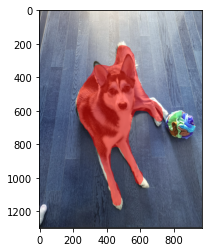

In [65]:
plt.imshow(output)
plt.show()

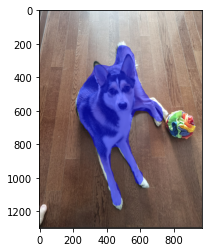

In [57]:
plt.imshow(seg_img_rgb)
plt.show()

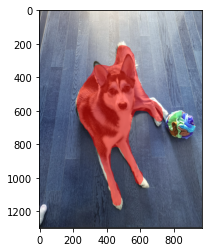

In [66]:
plt.imshow(seg_img)
plt.show()

In [59]:
if "instances" in segmask:
    for i, obj in enumerate(segmask["instances"]):
        print(f"Object {i+1}:")
        print("  Class:", obj["class"])
        print("  Box:", obj["box_points"])
        print("  Mask color:", obj["color"])
else:
    print("⚠️ 객체가 감지되지 않았거나, extract_segmented_objects=True가 아님.")

⚠️ 객체가 감지되지 않았거나, extract_segmented_objects=True가 아님.


In [60]:
import numpy as np

def create_pascal_colormap(num_classes=80):
    colormap = np.zeros((num_classes, 3), dtype=int)
    ind = np.arange(num_classes, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

coco_colormap = create_pascal_colormap(80)
print("dog (index 16):", coco_colormap[16])
print("sports ball (index 32):", coco_colormap[32])


dog (index 16): [ 0 64  0]
sports ball (index 32): [ 0  0 64]


In [70]:
# BGR -> RGB
dog_color = (0, 64, 0)

(1298, 968)


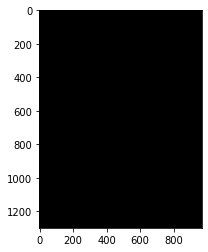

In [71]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다

seg_map = np.all(output==dog_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

[회고]
CocoDetection에는 데이타 클래스가 더 많긴 하지만, 장난감이 sports ball로는 인식되지 않았음
instance로 읽혀지지도 않았음